<h1 style="text-align: center; color: white"> Plotting cross section ratios as a function of Bjorken-x </h1>

<h2 style="text-align: center; color: orange"> For 35 deg </h2>

In [1]:
import uproot, time, sys
start_time = time.time()
sys.path.append('/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/xem2')
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy import stats
from common_functions import read_report, ImportRadcor, target_info, root_hist_to_numpy, csb, jra_nprat, datahist_from_array, mchist_from_array, cereff, baja, E, leaky_cauldron
from common_functions import LD2_dict, C12_dict, Dummy_dict, Fe54_dict, Ca40_dict, Be9_dict, Ca48_dict, B10_dict, B11_dict, He4_dict, He3_dict, C12_dict_l2, delta_correction
from common_functions import Sn119_dict, Ti48_dict, Ag108_dict, Th232_dict, Ni58_dict, Ni64_dict, Li7_dict, Li6_dict, Al27_dict, Cu63_dict, Au197_dict, cafe_report_path, tinfo_path
from common_functions import C12_26_dict, Dummy_26_dict, Ca40_26_dict, LD2_26_dict, LH2_26_dict, Ei, Mp, N_A, Q_E
from common_functions import He4_35_dict, He3_35_dict, Be9_35_dict, Dummy_35_dict, LH2_35_dict, Ca40_35_dict, LD2_35_dict, C12_35_dict

\begin{equation}
    \sigma^{Born}_{data} = \frac{Y_{data}}{Y_{MC}} \cdot \sigma^{Born}_{MC}
\end{equation}

In [2]:
folder = 'paintees'

ntg = 'C12' # What is the nuclei in numerator?
nsimstring = ntg.lower()
print("nsimstring", nsimstring)
dtg = 'LD2' # What is the nuclei in denominator?
dsimstring = dtg.lower()
print("dsimstring", dsimstring)
ald = 'Dummy' # Aluminium dummy target
dang = 35.0 # What is your desired angle?
antg = ntg + '_' + str(int(dang))  # Angle string for numerator nuclei
adtg = dtg + '_' + str(int(dang))  # Angle string for denominator nuclei
dmom = [1.63, 1.85, 2.11, 2.4, 2.72, 3.09, 3.57, 4.08] # What are your desired central momenta (just the magnitude)
bin_per_mom = 16 # How many bins per momentum?
bin_num = bin_per_mom * len(dmom) # Total number of bins in the combined histogram

# Kinematic variables
ts = dang # Spectrometer angle
Z, A = target_info[ntg][0], target_info[ntg][1]  # Target
thick = target_info[ntg][2] # g/cm2. From Cameron's target sheet column 'R'
ep_min = {}
ep_max = {}

# Constants
dpp_up, dpp_down = 10.0, -10.0 # Momentum acceptance upper and lower limit
cos_ts = np.cos(np.deg2rad(ts))
sin_ts = np.sin(np.deg2rad(ts))
print(antg)

for momentum in dmom:
    ep_min[momentum] = momentum * (1 + 0.01 * dpp_down)
    ep_max[momentum] = momentum * (1 + 0.01 * dpp_up)
    phi_up, phi_down, theta_up, theta_down = 100.0, -100.0, 65.0, -65.0 # mrad
    domega = (phi_up - phi_down) * (theta_up - theta_down) / 1e6  # diff solid angle in sr
    sim_charge = 1.
    lumin = thick * sim_charge / A * N_A / Q_E * 1e-39

nsimstring c12
dsimstring ld2
C12_35


<h1 align="center">DATA WORK FOR NTG</h1>

In [3]:
# target_dict = {
#     4.08: [5134],
#     3.57: [5228],
#     3.09: [5299],
#     2.72: [5394],
#     2.4: [5409],
#     2.11: [5437],
#     1.85: [5440],
#     1.63: [5461]
# }
# Just ELREAL
# target_dict = {
#     4.08: [5100, 5134, 5135, 5136, 5137, 5138, 5139, 5140, 5141, 5142, 5143, 5145, 5224, 5225, 5226, 6083, 6087, 6104, 6107, 6108, 6236, 6237, 6238, 6239, 6240, 6258, 6259, 6260, 6261, 6262, 6270, 6271, 6687, 6688, 6717, 6753, 6754, 6826, 6827, 6828],
#     3.57: [5228, 5229, 5230, 5231, 5232, 5233, 5234, 5292, 5293, 5294, 5295, 5296, 5297, 6123, 6126, 6291, 6292, 6293, 6295, 6296, 6297, 6299, 6302, 6303, 6304],
#     3.09: [5298, 5299, 5300, 5301, 5302, 5304, 5305, 5306, 5307, 5308, 5309, 5310, 6366, 6367, 6369, 6370, 6371, 6372, 6373, 6374, 6375, 6376, 6380, 6384, 6385],
#     2.72: [5394, 5395, 5396, 5397, 5398, 5399, 5400, 5401, 5402, 5403, 5404, 5405, 5406, 5407, 5408, 6386, 6387, 6388, 6389, 6390, 6391, 6392, 6393, 6394, 6395, 6396, 6397, 6408],
#     2.4: [5409, 5410, 5411, 6460, 6461, 6463, 6464],
#     2.11: [5439, 6473, 6474, 6475, 6477, 6478],
#     1.85: [5440, 5441, 6489, 6490],
#     1.63: [5461, 6505],
#     1.44: [5462, 5463, 6506],
#     1.26: [6523, 6524]
# }
# Ladder 2
# target_dict = {
#     4.08: [6083, 6087, 6104, 6107, 6108, 6236, 6237, 6238, 6239, 6240, 6258, 6259, 6260, 6261, 6262, 6270, 6271, 6687, 6688, 6717, 6753, 6754, 6826, 6827, 6828],
#     3.57: [6123, 6126, 6291, 6292, 6293, 6295, 6296, 6297, 6299, 6302, 6303, 6304],
#     3.09: [6366, 6367, 6369, 6370, 6371, 6372, 6373, 6374, 6375, 6376, 6380, 6384, 6385],
#     2.72: [6386, 6387, 6388, 6389, 6390, 6391, 6392, 6393, 6394, 6395, 6396, 6397, 6408],
#     2.4: [6460, 6461, 6463, 6464],
#     2.11: [6477, 6478],
#     1.85: [6489, 6490],
#     1.63: [6505],
#     1.44: [6506],
#     1.26: [6523, 6524]
# }
# Ladder 1
# target_dict = {
#     4.08: [5100, 5134, 5135, 5136, 5137, 5138, 5139, 5140, 5141, 5142, 5143, 5145, 5224, 5225, 5226],
#     3.57: [5228, 5229, 5230, 5231, 5232, 5233, 5234, 5292, 5293, 5294, 5295, 5296, 5297],
#     3.09: [5298, 5299, 5300, 5301, 5302, 5304, 5305, 5306, 5307, 5308, 5309, 5310],
#     2.72: [5394, 5395, 5396, 5397, 5398, 5399, 5400, 5401, 5402, 5403, 5404, 5405, 5406, 5407, 5408],
#     2.4: [5409, 5410, 5411],
#     2.11: [5439],
#     1.85: [5440, 5441],
#     1.63: [5461],
#     1.44: [5462, 5463],
#     1.26: [6523, 6524]
# }

In [4]:
target_dict_name = f'{antg}_dict'
target_dict = globals()[target_dict_name]
delta_hist = {}
theta_dict = {}
eff_weight = {}
data_delta = np.linspace(-8.0, 8.0, bin_per_mom + 1)

for momentum in dmom:
    files = [f'/Volumes/smriti/xem2/ROOTfiles/HMS_{run}_skim.root' for run in target_dict[momentum]]
    branches = ['H_gtr_dp', 'H_cal_etottracknorm', 'H_gtr_ph', 'H_gtr_th', 'H_cer_npeSum', 'H_bcm_CurrentFlag']
    electrons = uproot.concatenate(files, branches)

    data_cut = (np.abs(electrons['H_gtr_dp']) < 8) & (electrons['H_cal_etottracknorm'] > 0.7) & (np.abs(electrons['H_gtr_ph']) < 0.032) & (np.abs(electrons['H_gtr_th']) < 0.085) & (electrons['H_cer_npeSum'] > 2) & (electrons['H_bcm_CurrentFlag'] == 1)
    dp_cut = electrons['H_gtr_dp'][data_cut]
    theta_cut = electrons['H_gtr_th'][data_cut]
    phi_cut = electrons['H_gtr_ph'][data_cut]

    # Cherenkov efficiency correction
    eff_weight[momentum] = 1 / cereff(dp_cut)

    theta_dict[momentum] = np.rad2deg(np.arccos((cos_ts + phi_cut * sin_ts) / np.sqrt(1 + theta_cut * theta_cut + phi_cut * phi_cut)))
    delta_hist[momentum] = np.array(dp_cut)

Target dictionary found {4.08: [5134, 5135, 5136, 5137, 5138, 5139, 5140, 5141, 5142, 5143, 5145, 5146, 5147, 5223, 5224, 5225, 5226, 5291, 5292, 5293, 5294, 5295, 5296, 5297, 6365, 6366, 6367, 6369, 6370, 6371, 6372, 6373, 6374, 6375, 6376, 6826, 6827, 6828], 3.57: [5228, 5229, 5230, 5231, 5232, 5233, 5234, 5237, 6123, 6126, 6127, 6235, 6236, 6237, 6238, 6239, 6240], 3.09: [5298, 5299, 5300, 5301, 5302, 5304, 5305, 5306, 5307, 5308, 5309, 5310, 5311, 6365, 6366, 6367], 2.72: [5393, 5394, 5395, 5396, 5397, 5398, 5399, 5400, 5401, 5402, 5403, 5404, 5405], 2.4: [5409, 5410, 5411, 5412], 2.11: [5436, 5437], 1.85: [5440, 5441], 1.63: [5460, 5461]}
Mean scaling factor for C12_35 at 1.63 GeV/c is 2.8036959665332366e-05
Total scaling factor for C12_35 at 1.63 GeV/c is 71334.41085885625
Target dictionary found {4.08: [5134, 5135, 5136, 5137, 5138, 5139, 5140, 5141, 5142, 5143, 5145, 5146, 5147, 5223, 5224, 5225, 5226, 5291, 5292, 5293, 5294, 5295, 5296, 5297, 6365, 6366, 6367, 6369, 6370, 6371

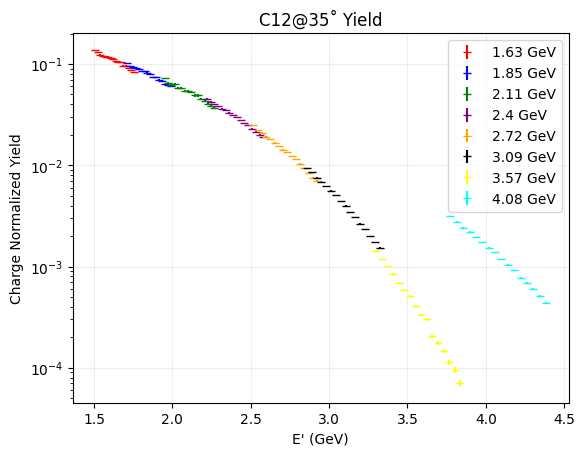

In [11]:
# Calculate the charge normalized yield and the uncertainty per bin
delta_bin_contents_1p63_ntg, delta_bin_errors_1p63_ntg = datahist_from_array(delta_hist[1.63], 1.63, data_delta, antg, eff_weight[1.63])
delta_bin_contents_1p85_ntg, delta_bin_errors_1p85_ntg = datahist_from_array(delta_hist[1.85], 1.85, data_delta, antg, eff_weight[1.85])
delta_bin_contents_2p11_ntg, delta_bin_errors_2p11_ntg = datahist_from_array(delta_hist[2.11], 2.11, data_delta, antg, eff_weight[2.11])
delta_bin_contents_2p4_ntg, delta_bin_errors_2p4_ntg = datahist_from_array(delta_hist[2.4], 2.4, data_delta, antg, eff_weight[2.4])
delta_bin_contents_2p72_ntg, delta_bin_errors_2p72_ntg = datahist_from_array(delta_hist[2.72], 2.72, data_delta, antg, eff_weight[2.72])
delta_bin_contents_3p09_ntg, delta_bin_errors_3p09_ntg = datahist_from_array(delta_hist[3.09], 3.09, data_delta, antg, eff_weight[3.09])
delta_bin_contents_3p57_ntg, delta_bin_errors_3p57_ntg = datahist_from_array(delta_hist[3.57], 3.57, data_delta, antg, eff_weight[3.57])
delta_bin_contents_4p08_ntg, delta_bin_errors_4p08_ntg = datahist_from_array(delta_hist[4.08], 4.08, data_delta, antg, eff_weight[4.08])

# Update the histogram and bin edges
_, delta_bin_edges_1p63 = np.histogram(delta_hist[1.63], bins=data_delta)
_, delta_bin_edges_1p85 = np.histogram(delta_hist[1.85], bins=data_delta)
_, delta_bin_edges_2p11 = np.histogram(delta_hist[2.11], bins=data_delta)
_, delta_bin_edges_2p4 = np.histogram(delta_hist[2.4], bins=data_delta)
_, delta_bin_edges_2p72 = np.histogram(delta_hist[2.72], bins=data_delta)
_, delta_bin_edges_3p09 = np.histogram(delta_hist[3.09], bins=data_delta)
_, delta_bin_edges_3p57 = np.histogram(delta_hist[3.57], bins=data_delta)
_, delta_bin_edges_4p08 = np.histogram(delta_hist[4.08], bins=data_delta)

# Calculate bin centers
delta_bin_centers_1p63 = (delta_bin_edges_1p63[:-1] + delta_bin_edges_1p63[1:]) / 2
delta_bin_centers_1p85 = (delta_bin_edges_1p85[:-1] + delta_bin_edges_1p85[1:]) / 2
delta_bin_centers_2p11 = (delta_bin_edges_2p11[:-1] + delta_bin_edges_2p11[1:]) / 2
delta_bin_centers_2p4 = (delta_bin_edges_2p4[:-1] + delta_bin_edges_2p4[1:]) / 2
delta_bin_centers_2p72 = (delta_bin_edges_2p72[:-1] + delta_bin_edges_2p72[1:]) / 2
delta_bin_centers_3p09 = (delta_bin_edges_3p09[:-1] + delta_bin_edges_3p09[1:]) / 2
delta_bin_centers_3p57 = (delta_bin_edges_3p57[:-1] + delta_bin_edges_3p57[1:]) / 2
delta_bin_centers_4p08 = (delta_bin_edges_4p08[:-1] + delta_bin_edges_4p08[1:]) / 2

# Update binned eprime bin centers
binned_eprime_bin_centers_1p63 = 1.63 * (1 + 0.01 * delta_bin_centers_1p63)
binned_eprime_bin_centers_1p85 = 1.85 * (1 + 0.01 * delta_bin_centers_1p85)
binned_eprime_bin_centers_2p11 = 2.11 * (1 + 0.01 * delta_bin_centers_2p11)
binned_eprime_bin_centers_2p4 = 2.4 * (1 + 0.01 * delta_bin_centers_2p4)
binned_eprime_bin_centers_2p72 = 2.72 * (1 + 0.01 * delta_bin_centers_2p72)
binned_eprime_bin_centers_3p09 = 3.09 * (1 + 0.01 * delta_bin_centers_3p09)
binned_eprime_bin_centers_3p57 = 3.57 * (1 + 0.01 * delta_bin_centers_3p57)
binned_eprime_bin_centers_4p08 = 4.08 * (1 + 0.01 * delta_bin_centers_4p08)

# Calculate the charge symmetric background fraction per bin
csb_frac_1p63_ntg = csb(binned_eprime_bin_centers_1p63, ntg, dang)
csb_frac_1p85_ntg = csb(binned_eprime_bin_centers_1p85, ntg, dang)
csb_frac_2p11_ntg = csb(binned_eprime_bin_centers_2p11, ntg, dang)
csb_frac_2p4_ntg = csb(binned_eprime_bin_centers_2p4, ntg, dang)
csb_frac_2p72_ntg = csb(binned_eprime_bin_centers_2p72, ntg, dang)
csb_frac_3p09_ntg = csb(binned_eprime_bin_centers_3p09, ntg, dang)
csb_frac_3p57_ntg = csb(binned_eprime_bin_centers_3p57, ntg, dang)
csb_frac_4p08_ntg = csb(binned_eprime_bin_centers_4p08, ntg, dang)

# Subtract the charge symmetric background fraction from the total yield
subtracted_csb_contents_1p63_ntg = delta_bin_contents_1p63_ntg * (1 - csb_frac_1p63_ntg)
subtracted_csb_contents_1p85_ntg = delta_bin_contents_1p85_ntg * (1 - csb_frac_1p85_ntg)
subtracted_csb_contents_2p11_ntg = delta_bin_contents_2p11_ntg * (1 - csb_frac_2p11_ntg)
subtracted_csb_contents_2p4_ntg = delta_bin_contents_2p4_ntg * (1 - csb_frac_2p4_ntg)
subtracted_csb_contents_2p72_ntg = delta_bin_contents_2p72_ntg * (1 - csb_frac_2p72_ntg)
subtracted_csb_contents_3p09_ntg = delta_bin_contents_3p09_ntg * (1 - csb_frac_3p09_ntg)
subtracted_csb_contents_3p57_ntg = delta_bin_contents_3p57_ntg * (1 - csb_frac_3p57_ntg)
subtracted_csb_contents_4p08_ntg = delta_bin_contents_4p08_ntg * (1 - csb_frac_4p08_ntg)

# Add the errors in quadrature
subtracted_csb_errors_1p63_ntg = delta_bin_errors_1p63_ntg * (1 - csb_frac_1p63_ntg)
subtracted_csb_errors_1p85_ntg = delta_bin_errors_1p85_ntg * (1 - csb_frac_1p85_ntg)
subtracted_csb_errors_2p11_ntg = delta_bin_errors_2p11_ntg * (1 - csb_frac_2p11_ntg)
subtracted_csb_errors_2p4_ntg = delta_bin_errors_2p4_ntg * (1 - csb_frac_2p4_ntg)
subtracted_csb_errors_2p72_ntg = delta_bin_errors_2p72_ntg * (1 - csb_frac_2p72_ntg)
subtracted_csb_errors_3p09_ntg = delta_bin_errors_3p09_ntg * (1 - csb_frac_3p09_ntg)
subtracted_csb_errors_3p57_ntg = delta_bin_errors_3p57_ntg * (1 - csb_frac_3p57_ntg)
subtracted_csb_errors_4p08_ntg = delta_bin_errors_4p08_ntg * (1 - csb_frac_4p08_ntg)

# fig refers to the entire canvas on which plots are drawn. ax refers to a single plot/subplot
fig, ax = plt.subplots()
ax.errorbar(binned_eprime_bin_centers_1p63, delta_bin_contents_1p63_ntg, yerr = delta_bin_errors_1p63_ntg, fmt = '_', color = 'red', label = '1.63 GeV')
ax.errorbar(binned_eprime_bin_centers_1p85, delta_bin_contents_1p85_ntg, yerr = delta_bin_errors_1p85_ntg, fmt = '_', color = 'blue', label = '1.85 GeV')
ax.errorbar(binned_eprime_bin_centers_2p11, delta_bin_contents_2p11_ntg, yerr = delta_bin_errors_2p11_ntg, fmt = '_', color = 'green', label = '2.11 GeV')
ax.errorbar(binned_eprime_bin_centers_2p4, delta_bin_contents_2p4_ntg, yerr = delta_bin_errors_2p4_ntg, fmt = '_', color = 'purple', label = '2.4 GeV')
ax.errorbar(binned_eprime_bin_centers_2p72, delta_bin_contents_2p72_ntg, yerr = delta_bin_errors_2p72_ntg, fmt = '_', color = 'orange', label = '2.72 GeV')
ax.errorbar(binned_eprime_bin_centers_3p09, delta_bin_contents_3p09_ntg, yerr = delta_bin_errors_3p09_ntg, fmt = '_', color = 'black', label = '3.09 GeV')
ax.errorbar(binned_eprime_bin_centers_3p57, delta_bin_contents_3p57_ntg, yerr = delta_bin_errors_3p57_ntg, fmt = '_', color = 'yellow', label = '3.57 GeV')
ax.errorbar(binned_eprime_bin_centers_4p08, delta_bin_contents_4p08_ntg, yerr = delta_bin_errors_4p08_ntg, fmt = '_', color = 'cyan', label = '4.08 GeV')
ax.set_ylabel('Charge Normalized Yield')
ax.set_xlabel('E\' (GeV)')
ax.set_title(f'{ntg}@{int(dang)}˚')
ax.legend()
ax.grid(alpha = 0.2)
ax.set_yscale('log')
# fig.savefig(f'{folder}/{nsimstring}_{dsimstring}_newyield.pdf')

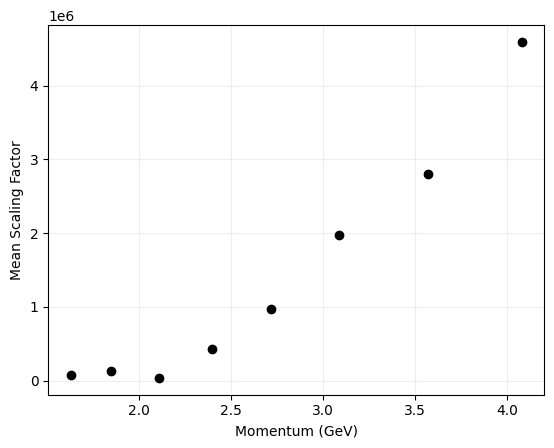

In [6]:
mean_scaling_factors_C12_35 = [35667.205429428126, 64240.54952393276, 18033.072271654462, 106480.53490437267, 74455.03575150884, 123639.14306408267, 164822.0910507613, 120921.29291024902]
total_scaling_factors = [
    71334.41085885625,  # 1.63 GeV/c
    128481.09904786551,  # 1.85 GeV/c
    36066.144543308925,  # 2.11 GeV/c
    425922.1396174907,  # 2.4 GeV/c
    967915.464769615,  # 2.72 GeV/c
    1978226.2890253223,  # 3.09 GeV/c
    2801975.547862941,  # 3.57 GeV/c
    4595009.130589464  # 4.08 GeV/c
]
plt.plot(dmom, total_scaling_factors, 'o', color = 'black')
plt.xlabel('Momentum (GeV)')
plt.ylabel('Mean Scaling Factor')
plt.grid(alpha = 0.2)
# plt.savefig(f'{folder}/mean_scaling_factors_{ntg}.pdf')

<h1 align = 'center'> TARGET SPECIFIC DATA YIELD CORRECTION</h1>

In [7]:
if ntg == 'Ca48':
    print("Correcting for Ca40 contamination in Ca48 target")
    C = 0.113 # Ratio of Ca40 contamination in Ca48 target to Ca40 target
    cont_tg = 'Ca40'

elif ntg == 'B10':
    print("Correcting for C12 contamination in B10 target")
    C = 0.231 # Ratio of C12 contamination in B10 target to C12 target
    cont_tg = 'C12'

elif ntg == 'B11':
    print("Correcting for C12 contamination in B11 target")
    C = 0.236 # Ratio of C12 contamination in B11 target to C12 target
    cont_tg = 'C12'

elif ntg == 'He3' or ntg == 'LD2':
    print("Performing Aluminum cell wall subtraction")
    C = 0.2165 # Mean of Ratio of upstream & downstream dummy to target cell thickness
    acont_tg = ald + '_' + str(int(dang))
    
else:
    print("No contamination correction needed")
    C = 0

if C != 0:
    cont_dict_name = f'{acont_tg}_dict' # Dictionary containing the runs for the contaminant
    cont_dict = globals()[cont_dict_name]    
    for momentum in dmom:
        files = [f'/Volumes/smriti/xem2/ROOTfiles/HMS_{run}_skim.root' for run in cont_dict[momentum]]
        branches = ['H_gtr_dp', 'H_cal_etottracknorm', 'H_gtr_ph', 'H_gtr_th', 'H_cer_npeSum', 'H_bcm_CurrentFlag']
        electrons = uproot.concatenate(files, branches)

        data_cut = (np.abs(electrons['H_gtr_dp']) < 8) & (electrons['H_cal_etottracknorm'] > 0.7) & (np.abs(electrons['H_gtr_ph']) < 0.032) & (np.abs(electrons['H_gtr_th']) < 0.085) & (electrons['H_cer_npeSum'] > 2) & (electrons['H_bcm_CurrentFlag'] == 1)
        dp_cut = electrons['H_gtr_dp'][data_cut]
        theta_cut = electrons['H_gtr_th'][data_cut]
        phi_cut = electrons['H_gtr_ph'][data_cut]

        eff_weight[momentum] = 1 / cereff(dp_cut) # Cherenkov efficiency correction

        theta_dict[momentum] = np.rad2deg(np.arccos((cos_ts + phi_cut * sin_ts) / np.sqrt(1 + theta_cut * theta_cut + phi_cut * phi_cut)))
        delta_hist[momentum] = np.array(dp_cut)
    # Get yield and yield error from array
    contaminant_eprime_bin_contents_1p63, contaminant_eprime_bin_errors_1p63 = datahist_from_array(delta_hist[1.63], 1.63, data_delta, acont_tg, eff_weight[1.63])
    contaminant_eprime_bin_contents_1p85, contaminant_eprime_bin_errors_1p85 = datahist_from_array(delta_hist[1.85], 1.85, data_delta, acont_tg, eff_weight[1.85])
    contaminant_eprime_bin_contents_2p11, contaminant_eprime_bin_errors_2p11 = datahist_from_array(delta_hist[2.11], 2.11, data_delta, acont_tg, eff_weight[2.11])
    contaminant_eprime_bin_contents_2p4, contaminant_eprime_bin_errors_2p4 = datahist_from_array(delta_hist[2.4], 2.4, data_delta, acont_tg, eff_weight[2.4])
    contaminant_eprime_bin_contents_2p72, contaminant_eprime_bin_errors_2p72 = datahist_from_array(delta_hist[2.72], 2.72, data_delta, acont_tg, eff_weight[2.72])
    contaminant_eprime_bin_contents_3p09, contaminant_eprime_bin_errors_3p09 = datahist_from_array(delta_hist[3.09], 3.09, data_delta, acont_tg, eff_weight[3.09])
    contaminant_eprime_bin_contents_3p57, contaminant_eprime_bin_errors_3p57 = datahist_from_array(delta_hist[3.57], 3.57, data_delta, acont_tg, eff_weight[3.57])
    contaminant_eprime_bin_contents_4p08, contaminant_eprime_bin_errors_4p08 = datahist_from_array(delta_hist[4.08], 4.08, data_delta, acont_tg, eff_weight[4.08])

    # Calculate the charge symmetric background fraction per bin for contaminant
    csb_frac_1p63_cont = csb(binned_eprime_bin_centers_1p63, acont_tg, dang)
    csb_frac_1p85_cont = csb(binned_eprime_bin_centers_1p85, acont_tg, dang)
    csb_frac_2p11_cont = csb(binned_eprime_bin_centers_2p11, acont_tg, dang)
    csb_frac_2p4_cont = csb(binned_eprime_bin_centers_2p4, acont_tg, dang)
    csb_frac_2p72_cont = csb(binned_eprime_bin_centers_2p72, acont_tg, dang)
    csb_frac_3p09_cont = csb(binned_eprime_bin_centers_3p09, acont_tg, dang)
    csb_frac_3p57_cont = csb(binned_eprime_bin_centers_3p57, acont_tg, dang)
    csb_frac_4p08_cont = csb(binned_eprime_bin_centers_4p08, acont_tg, dang)

    # Error propagation
    contaminant_eprime_bin_errors_1p63 = contaminant_eprime_bin_errors_1p63 * (1 - csb_frac_1p63_cont)
    contaminant_eprime_bin_errors_1p85 = contaminant_eprime_bin_errors_1p85 * (1 - csb_frac_1p85_cont)
    contaminant_eprime_bin_errors_2p11 = contaminant_eprime_bin_errors_2p11 * (1 - csb_frac_2p11_cont)
    contaminant_eprime_bin_errors_2p4 = contaminant_eprime_bin_errors_2p4 * (1 - csb_frac_2p4_cont)
    contaminant_eprime_bin_errors_2p72 = contaminant_eprime_bin_errors_2p72 * (1 - csb_frac_2p72_cont)
    contaminant_eprime_bin_errors_3p09 = contaminant_eprime_bin_errors_3p09 * (1 - csb_frac_3p09_cont)
    contaminant_eprime_bin_errors_3p57 = contaminant_eprime_bin_errors_3p57 * (1 - csb_frac_3p57_cont)
    contaminant_eprime_bin_errors_4p08 = contaminant_eprime_bin_errors_4p08 * (1 - csb_frac_4p08_cont)

    # Subtract CSB from the total yield of the contaminant
    subtracted_bin_contents_1p63_cont = contaminant_eprime_bin_contents_1p63 * (1 - csb_frac_1p63_cont)
    subtracted_bin_contents_1p85_cont = contaminant_eprime_bin_contents_1p85 * (1 - csb_frac_1p85_cont)
    subtracted_bin_contents_2p11_cont = contaminant_eprime_bin_contents_2p11 * (1 - csb_frac_2p11_cont)
    subtracted_bin_contents_2p4_cont = contaminant_eprime_bin_contents_2p4 * (1 - csb_frac_2p4_cont)
    subtracted_bin_contents_2p72_cont = contaminant_eprime_bin_contents_2p72 * (1 - csb_frac_2p72_cont)
    subtracted_bin_contents_3p09_cont = contaminant_eprime_bin_contents_3p09 * (1 - csb_frac_3p09_cont)
    subtracted_bin_contents_3p57_cont = contaminant_eprime_bin_contents_3p57 * (1 - csb_frac_3p57_cont)
    subtracted_bin_contents_4p08_cont = contaminant_eprime_bin_contents_4p08 * (1 - csb_frac_4p08_cont)

    # Perform Contamination Subtraction
    subtracted_bin_contents_1p63_ntg = subtracted_csb_contents_1p63_ntg - (C * subtracted_bin_contents_1p63_cont)
    subtracted_bin_contents_1p85_ntg = subtracted_csb_contents_1p85_ntg - (C * subtracted_bin_contents_1p85_cont)
    subtracted_bin_contents_2p11_ntg = subtracted_csb_contents_2p11_ntg - (C * subtracted_bin_contents_2p11_cont)
    subtracted_bin_contents_2p4_ntg = subtracted_csb_contents_2p4_ntg - (C * subtracted_bin_contents_2p4_cont)
    subtracted_bin_contents_2p72_ntg = subtracted_csb_contents_2p72_ntg - (C * subtracted_bin_contents_2p72_cont)
    subtracted_bin_contents_3p09_ntg = subtracted_csb_contents_3p09_ntg - (C * subtracted_bin_contents_3p09_cont)
    subtracted_bin_contents_3p57_ntg = subtracted_csb_contents_3p57_ntg - (C * subtracted_bin_contents_3p57_cont)
    subtracted_bin_contents_4p08_ntg = subtracted_csb_contents_4p08_ntg - (C * subtracted_bin_contents_4p08_cont)

    # Add the errors in quadrature
    subtracted_bin_errors_1p63_ntg = np.sqrt((subtracted_csb_errors_1p63_ntg)**2 + (C * contaminant_eprime_bin_errors_1p63)**2)
    subtracted_bin_errors_1p85_ntg = np.sqrt((subtracted_csb_errors_1p85_ntg)**2 + (C * contaminant_eprime_bin_errors_1p85)**2)
    subtracted_bin_errors_2p11_ntg = np.sqrt((subtracted_csb_errors_2p11_ntg)**2 + (C * contaminant_eprime_bin_errors_2p11)**2)
    subtracted_bin_errors_2p4_ntg = np.sqrt((subtracted_csb_errors_2p4_ntg)**2 + (C * contaminant_eprime_bin_errors_2p4)**2)
    subtracted_bin_errors_2p72_ntg = np.sqrt((subtracted_csb_errors_2p72_ntg)**2 + (C * contaminant_eprime_bin_errors_2p72)**2)
    subtracted_bin_errors_3p09_ntg = np.sqrt((subtracted_csb_errors_3p09_ntg)**2 + (C * contaminant_eprime_bin_errors_3p09)**2)
    subtracted_bin_errors_3p57_ntg = np.sqrt((subtracted_csb_errors_3p57_ntg)**2 + (C * contaminant_eprime_bin_errors_3p57)**2)
    subtracted_bin_errors_4p08_ntg = np.sqrt((subtracted_csb_errors_4p08_ntg)**2 + (C * contaminant_eprime_bin_errors_4p08)**2)

    # Updated plot
    fig, ax = plt.subplots()
    ax.errorbar(binned_eprime_bin_centers_1p63, subtracted_bin_contents_1p63_ntg, yerr=subtracted_bin_errors_1p63_ntg, fmt='_', color='red', label='1.63 GeV')
    ax.errorbar(binned_eprime_bin_centers_1p85, subtracted_bin_contents_1p85_ntg, yerr=subtracted_bin_errors_1p85_ntg, fmt='_', color='blue', label='1.85 GeV')
    ax.errorbar(binned_eprime_bin_centers_2p11, subtracted_bin_contents_2p11_ntg, yerr=subtracted_bin_errors_2p11_ntg, fmt='_', color='green', label='2.11 GeV')
    ax.errorbar(binned_eprime_bin_centers_2p4, subtracted_bin_contents_2p4_ntg, yerr=subtracted_bin_errors_2p4_ntg, fmt='_', color='orange', label='2.4 GeV')
    ax.errorbar(binned_eprime_bin_centers_2p72, subtracted_bin_contents_2p72_ntg, yerr=subtracted_bin_errors_2p72_ntg, fmt='_', color='purple', label='2.72 GeV')
    ax.errorbar(binned_eprime_bin_centers_3p09, subtracted_bin_contents_3p09_ntg, yerr=subtracted_bin_errors_3p09_ntg, fmt='_', color='yellow', label='3.09 GeV')
    ax.errorbar(binned_eprime_bin_centers_3p57, subtracted_bin_contents_3p57_ntg, yerr=subtracted_bin_errors_3p57_ntg, fmt='_', color='pink', label='3.57 GeV')
    ax.errorbar(binned_eprime_bin_centers_4p08, subtracted_bin_contents_4p08_ntg, yerr=subtracted_bin_errors_4p08_ntg, fmt='_', color='brown', label='4.08 GeV')
    ax.set_xlabel('Eprime (GeV)')
    ax.set_ylabel('Charge Normalized Yield')
    ax.set_title('Data-Contamination Subtracted')
    ax.grid(alpha = 0.2)
    # ax.set_yscale('log')
    # fig.savefig(f'{folder}/plots/contamination_subtraction_yield_{ntg}_{time.time():.0f}.pdf')

No contamination correction needed


<h1 align="center">SIMULATION WORK FOR NTG</h1>


In [8]:
# Read the Cross-section table
V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13 = ImportRadcor(f"/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/xem2/xsec_tables/xem2_emc_rc_{nsimstring}22_hms.out")

Eprime_dict = {}
delta_dict = {}
xsec_array = {}
mc_scale = {}
thetadict = {}
ytar_weight = {}
ytarcut = {}
jacobian_weight = {}
delta_weight = {}
idang = int(dang)

for momentum in dmom:
    mom_str = str(momentum).replace('-', '').replace('.', 'p').rstrip('0')
    # mom_str = str(momentum).replace('-', '').replace('.', 'p')
    # filepath = f"/Volumes/smriti/xem2/worksim/hms_mc_{nsimstring}_{idang}degm{mom_str}.root"
    # New MC files
    filepath = f"/Volumes/smriti/xem2/worksim/hms_{idang}deg_{mom_str}gev_{nsimstring}.root"

    # Open the file and tree
    file = uproot.open(filepath)
    tree = file["h10"]

    # Load the branches
    electrons = tree.arrays(["hsdeltai", "hsytar", "hsyptari", "hsxptari", "stop_id"], library = 'np')    
    nentries = len(electrons["hsdeltai"])

    # Apply the cuts
    mc_cut = (np.abs(electrons["hsdeltai"]) <= 8) & \
            (np.abs(electrons["hsyptari"]) < 0.032) & \
            (np.abs(electrons["hsxptari"]) < 0.085) & \
            (electrons["stop_id"] == 0)
    
    # Filter 'hsdelta' with the cuts
    hsdelta_cut = electrons["hsdeltai"][mc_cut]
    hsyptar_cut = electrons["hsyptari"][mc_cut]
    hsxptar_cut = electrons["hsxptari"][mc_cut]
    hsytar_cut = electrons["hsytar"][mc_cut]

    delta_dict[momentum] = hsdelta_cut

    # Dave's delta correction
    delta_weight[momentum] = delta_correction(hsdelta_cut)

    # Calculate E' and theta (in degrees)
    Eprime_dict[momentum] = momentum * (1 + 0.01 * hsdelta_cut)
    thetarad = np.arccos((cos_ts + hsyptar_cut * sin_ts) / np.sqrt(1 + hsxptar_cut * hsxptar_cut + hsyptar_cut * hsyptar_cut))
    thetadeg = np.rad2deg(thetarad)

    # Calculate the ytar acceptance correction factor
    ytar_weight[momentum] = -0.00812174 * hsytar_cut**2 - 0.0000415678 * hsytar_cut + 1.00021
    ytarcut[momentum] = hsytar_cut

    # MC Jacobian
    jacobian_weight[momentum] = np.power((1 + np.power(hsxptar_cut, 2) + np.power(hsyptar_cut, 2)), -1.5)
        
    # Perform the interpolation
    points_ntg = np.array([V2, V3]).T # Make a 2D array and transpose it so each array is of the form [E',theta]
    points_to_interpolate = np.column_stack((Eprime_dict[momentum], thetadeg))
    xsec_array[momentum] = griddata(points_ntg, V9, points_to_interpolate, method = 'linear') # Specify the 2D array of [E's, thetas] as first argument; Radiative cross-section (V9) as the z-axis and (Ep, theta) as the point for which we need the cross-section
    mc_scale[momentum] = (lumin * domega * (ep_max[momentum] - ep_min[momentum])) / nentries         # Calculate the scale for simulation
    # print(f"Scale for {momentum} GeV: {mc_scale[momentum]}")
    thetadict[momentum] = thetadeg

hsdelta_min, hsdelta_max = np.min(delta_dict[dmom[0]]), np.max(delta_dict[dmom[0]])
print("Should be -8 and +8", hsdelta_min, hsdelta_max)
hsdelta_binedges = np.linspace(hsdelta_min, hsdelta_max, bin_per_mom + 1)

# This function returns 2 arrays: bin counts (the counts in each bin taking weights into account) and bin edges (the edges of the bins)
bin_edges_delta_1p63 = np.histogram(delta_dict[1.63], weights = xsec_array[1.63] * mc_scale[1.63], bins = hsdelta_binedges)[1]
bin_edges_delta_1p85 = np.histogram(delta_dict[1.85], weights = xsec_array[1.85] * mc_scale[1.85], bins = hsdelta_binedges)[1]
bin_edges_delta_2p11 = np.histogram(delta_dict[2.11], weights = xsec_array[2.11] * mc_scale[2.11], bins = hsdelta_binedges)[1]
bin_edges_delta_2p4 = np.histogram(delta_dict[2.4], weights = xsec_array[2.4] * mc_scale[2.4], bins = hsdelta_binedges)[1]
bin_edges_delta_2p72 = np.histogram(delta_dict[2.72], weights = xsec_array[2.72] * mc_scale[2.72], bins = hsdelta_binedges)[1]
bin_edges_delta_3p09 = np.histogram(delta_dict[3.09], weights = xsec_array[3.09] * mc_scale[3.09], bins = hsdelta_binedges)[1]
bin_edges_delta_3p57 = np.histogram(delta_dict[3.57], weights = xsec_array[3.57] * mc_scale[3.57], bins = hsdelta_binedges)[1]
bin_edges_delta_4p08 = np.histogram(delta_dict[4.08], weights = xsec_array[4.08] * mc_scale[4.08], bins = hsdelta_binedges)[1]

# Gets the yield and yield error
bin_counts_eprime_1p63_mc_ntg, bin_errors_eprime_1p63_mc_ntg = mchist_from_array(delta_dict[1.63], xsec_array[1.63] * mc_scale[1.63] * ytar_weight[1.63] * jacobian_weight[1.63] * delta_weight[1.63], hsdelta_binedges)
bin_counts_eprime_1p85_mc_ntg, bin_errors_eprime_1p85_mc_ntg = mchist_from_array(delta_dict[1.85], xsec_array[1.85] * mc_scale[1.85] * ytar_weight[1.85] * jacobian_weight[1.85] * delta_weight[1.85], hsdelta_binedges)
bin_counts_eprime_2p11_mc_ntg, bin_errors_eprime_2p11_mc_ntg = mchist_from_array(delta_dict[2.11], xsec_array[2.11] * mc_scale[2.11] * ytar_weight[2.11] * jacobian_weight[2.11] * delta_weight[2.11], hsdelta_binedges)
bin_counts_eprime_2p4_mc_ntg, bin_errors_eprime_2p4_mc_ntg = mchist_from_array(delta_dict[2.4], xsec_array[2.4] * mc_scale[2.4] * ytar_weight[2.4] * jacobian_weight[2.4] * delta_weight[2.4], hsdelta_binedges)
bin_counts_eprime_2p72_mc_ntg, bin_errors_eprime_2p72_mc_ntg = mchist_from_array(delta_dict[2.72], xsec_array[2.72] * mc_scale[2.72] * ytar_weight[2.72] * jacobian_weight[2.72] * delta_weight[2.72], hsdelta_binedges)
bin_counts_eprime_3p09_mc_ntg, bin_errors_eprime_3p09_mc_ntg = mchist_from_array(delta_dict[3.09], xsec_array[3.09] * mc_scale[3.09] * ytar_weight[3.09] * jacobian_weight[3.09] * delta_weight[3.09], hsdelta_binedges)
bin_counts_eprime_3p57_mc_ntg, bin_errors_eprime_3p57_mc_ntg = mchist_from_array(delta_dict[3.57], xsec_array[3.57] * mc_scale[3.57] * ytar_weight[3.57] * jacobian_weight[3.57] * delta_weight[3.57], hsdelta_binedges)
bin_counts_eprime_4p08_mc_ntg, bin_errors_eprime_4p08_mc_ntg = mchist_from_array(delta_dict[4.08], xsec_array[4.08] * mc_scale[4.08] * ytar_weight[4.08] * jacobian_weight[4.08] * delta_weight[4.08], hsdelta_binedges)

# Calculate bin centers
bin_centers_delta_1p63 = (bin_edges_delta_1p63[:-1] + bin_edges_delta_1p63[1:]) / 2
bin_centers_delta_1p85 = (bin_edges_delta_1p85[:-1] + bin_edges_delta_1p85[1:]) / 2
bin_centers_delta_2p11 = (bin_edges_delta_2p11[:-1] + bin_edges_delta_2p11[1:]) / 2
bin_centers_delta_2p4 = (bin_edges_delta_2p4[:-1] + bin_edges_delta_2p4[1:]) / 2
bin_centers_delta_2p72 = (bin_edges_delta_2p72[:-1] + bin_edges_delta_2p72[1:]) / 2
bin_centers_delta_3p09 = (bin_edges_delta_3p09[:-1] + bin_edges_delta_3p09[1:]) / 2
bin_centers_delta_3p57 = (bin_edges_delta_3p57[:-1] + bin_edges_delta_3p57[1:]) / 2
bin_centers_delta_4p08 = (bin_edges_delta_4p08[:-1] + bin_edges_delta_4p08[1:]) / 2

# Calculate binned eprime bin centers
binned_eprime_bin_centers_1p63_mc_ntg = 1.63 * (1 + 0.01 * bin_centers_delta_1p63)
binned_eprime_bin_centers_1p85_mc_ntg = 1.85 * (1 + 0.01 * bin_centers_delta_1p85)
binned_eprime_bin_centers_2p11_mc_ntg = 2.11 * (1 + 0.01 * bin_centers_delta_2p11)
binned_eprime_bin_centers_2p4_mc_ntg = 2.4 * (1 + 0.01 * bin_centers_delta_2p4)
binned_eprime_bin_centers_2p72_mc_ntg = 2.72 * (1 + 0.01 * bin_centers_delta_2p72)
binned_eprime_bin_centers_3p09_mc_ntg = 3.09 * (1 + 0.01 * bin_centers_delta_3p09)
binned_eprime_bin_centers_3p57_mc_ntg = 3.57 * (1 + 0.01 * bin_centers_delta_3p57)
binned_eprime_bin_centers_4p08_mc_ntg = 4.08 * (1 + 0.01 * bin_centers_delta_4p08)

# Plotting the histogram with error bars
fig2, ax2 = plt.subplots()
ax2.errorbar(binned_eprime_bin_centers_1p63_mc_ntg, bin_counts_eprime_1p63_mc_ntg, yerr=bin_errors_eprime_1p63_mc_ntg, fmt='_', color='black', label='Sim 1.63 GeV')
ax2.errorbar(binned_eprime_bin_centers_1p85_mc_ntg, bin_counts_eprime_1p85_mc_ntg, yerr=bin_errors_eprime_1p85_mc_ntg, fmt='_', color='black', label='Sim 1.85 GeV')
ax2.errorbar(binned_eprime_bin_centers_2p11_mc_ntg, bin_counts_eprime_2p11_mc_ntg, yerr=bin_errors_eprime_2p11_mc_ntg, fmt='_', color='black', label='Sim 2.11 GeV')
ax2.errorbar(binned_eprime_bin_centers_2p4_mc_ntg, bin_counts_eprime_2p4_mc_ntg, yerr=bin_errors_eprime_2p4_mc_ntg, fmt='_', color='black', label='Sim 2.4 GeV')
ax2.errorbar(binned_eprime_bin_centers_2p72_mc_ntg, bin_counts_eprime_2p72_mc_ntg, yerr=bin_errors_eprime_2p72_mc_ntg, fmt='_', color='black', label='Sim 2.72 GeV')
ax2.errorbar(binned_eprime_bin_centers_3p09_mc_ntg, bin_counts_eprime_3p09_mc_ntg, yerr=bin_errors_eprime_3p09_mc_ntg, fmt='_', color='black', label='Sim 3.09 GeV')
ax2.errorbar(binned_eprime_bin_centers_3p57_mc_ntg, bin_counts_eprime_3p57_mc_ntg, yerr=bin_errors_eprime_3p57_mc_ntg, fmt='_', color='black', label='Sim 3.57 GeV')
ax2.errorbar(binned_eprime_bin_centers_4p08_mc_ntg, bin_counts_eprime_4p08_mc_ntg, yerr=bin_errors_eprime_4p08_mc_ntg, fmt='_', color='black', label='Sim 4.08 GeV')
ax2.grid(alpha = 0.2)
ax2.set_xlabel('Eprime')
ax2.set_ylabel('Simulation Yield')
ax2.set_yscale('log')
# ax.legend() 
ax2.set_title(f'{ntg}@{dang}˚ Simulation')
# fig2.savefig(f'{folder}/eprime_{ntg}_{dang}_{start_time:.0f}.pdf')

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/smriti/xem2/worksim/hms_35deg_1p63gev_c12.root'

In [9]:
if C == 0:
    subtracted_bin_contents_1p95_ntg = subtracted_csb_contents_1p95_ntg
    subtracted_bin_contents_2p21_ntg = subtracted_csb_contents_2p21_ntg
    subtracted_bin_contents_2p52_ntg = subtracted_csb_contents_2p52_ntg
    subtracted_bin_contents_2p86_ntg = subtracted_csb_contents_2p86_ntg
    subtracted_bin_contents_3p25_ntg = subtracted_csb_contents_3p25_ntg
    subtracted_bin_contents_3p69_ntg = subtracted_csb_contents_3p69_ntg
    subtracted_bin_contents_4p19_ntg = subtracted_csb_contents_4p19_ntg
    subtracted_bin_contents_4p767_ntg = subtracted_csb_contents_4p767_ntg
    subtracted_bin_contents_5p42_ntg = subtracted_csb_contents_5p42_ntg

    subtracted_bin_errors_1p95_ntg = subtracted_csb_errors_1p95_ntg
    subtracted_bin_errors_2p21_ntg = subtracted_csb_errors_2p21_ntg
    subtracted_bin_errors_2p52_ntg = subtracted_csb_errors_2p52_ntg
    subtracted_bin_errors_2p86_ntg = subtracted_csb_errors_2p86_ntg
    subtracted_bin_errors_3p25_ntg = subtracted_csb_errors_3p25_ntg
    subtracted_bin_errors_3p69_ntg = subtracted_csb_errors_3p69_ntg
    subtracted_bin_errors_4p19_ntg = subtracted_csb_errors_4p19_ntg
    subtracted_bin_errors_4p767_ntg = subtracted_csb_errors_4p767_ntg
    subtracted_bin_errors_5p42_ntg = subtracted_csb_errors_5p42_ntg

<h1 align="center">DATA/SIMULATION YIELD RATIO FOR NTG</h1>


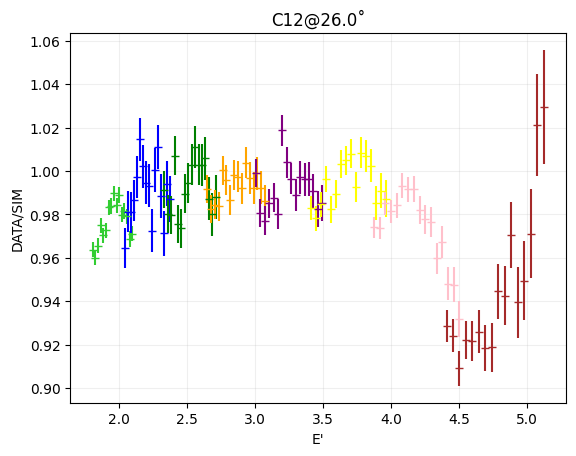

In [10]:
ratio_eprime_1p95_ntg = subtracted_bin_contents_1p95_ntg / bin_counts_eprime_1p95_mc_ntg
ratio_eprime_2p21_ntg = subtracted_bin_contents_2p21_ntg / bin_counts_eprime_2p21_mc_ntg
ratio_eprime_2p52_ntg = subtracted_bin_contents_2p52_ntg / bin_counts_eprime_2p52_mc_ntg
ratio_eprime_2p86_ntg = subtracted_bin_contents_2p86_ntg / bin_counts_eprime_2p86_mc_ntg
ratio_eprime_3p25_ntg = subtracted_bin_contents_3p25_ntg / bin_counts_eprime_3p25_mc_ntg
ratio_eprime_3p69_ntg = subtracted_bin_contents_3p69_ntg / bin_counts_eprime_3p69_mc_ntg
ratio_eprime_4p19_ntg = subtracted_bin_contents_4p19_ntg / bin_counts_eprime_4p19_mc_ntg
ratio_eprime_4p767_ntg = subtracted_bin_contents_4p767_ntg / bin_counts_eprime_4p767_mc_ntg
ratio_eprime_5p42_ntg = subtracted_bin_contents_5p42_ntg / bin_counts_eprime_5p42_mc_ntg

# Add errors in quadrature. First is data and second is MC
ratio_errors_1p95_ntg = ratio_eprime_1p95_ntg * np.sqrt((subtracted_bin_errors_1p95_ntg / subtracted_bin_contents_1p95_ntg)**2 + (bin_errors_eprime_1p95_mc_ntg / bin_counts_eprime_1p95_mc_ntg)**2)
ratio_errors_2p21_ntg = ratio_eprime_2p21_ntg * np.sqrt((subtracted_bin_errors_2p21_ntg / subtracted_bin_contents_2p21_ntg)**2 + (bin_errors_eprime_2p21_mc_ntg / bin_counts_eprime_2p21_mc_ntg)**2)
ratio_errors_2p52_ntg = ratio_eprime_2p52_ntg * np.sqrt((subtracted_bin_errors_2p52_ntg / subtracted_bin_contents_2p52_ntg)**2 + (bin_errors_eprime_2p52_mc_ntg / bin_counts_eprime_2p52_mc_ntg)**2)
ratio_errors_2p86_ntg = ratio_eprime_2p86_ntg * np.sqrt((subtracted_bin_errors_2p86_ntg / subtracted_bin_contents_2p86_ntg)**2 + (bin_errors_eprime_2p86_mc_ntg / bin_counts_eprime_2p86_mc_ntg)**2)
ratio_errors_3p25_ntg = ratio_eprime_3p25_ntg * np.sqrt((subtracted_bin_errors_3p25_ntg / subtracted_bin_contents_3p25_ntg)**2 + (bin_errors_eprime_3p25_mc_ntg / bin_counts_eprime_3p25_mc_ntg)**2)
ratio_errors_3p69_ntg = ratio_eprime_3p69_ntg * np.sqrt((subtracted_bin_errors_3p69_ntg / subtracted_bin_contents_3p69_ntg)**2 + (bin_errors_eprime_3p69_mc_ntg / bin_counts_eprime_3p69_mc_ntg)**2)
ratio_errors_4p19_ntg = ratio_eprime_4p19_ntg * np.sqrt((subtracted_bin_errors_4p19_ntg / subtracted_bin_contents_4p19_ntg)**2 + (bin_errors_eprime_4p19_mc_ntg / bin_counts_eprime_4p19_mc_ntg)**2)
ratio_errors_4p767_ntg = ratio_eprime_4p767_ntg * np.sqrt((subtracted_bin_errors_4p767_ntg / subtracted_bin_contents_4p767_ntg)**2 + (bin_errors_eprime_4p767_mc_ntg / bin_counts_eprime_4p767_mc_ntg)**2)
ratio_errors_5p42_ntg = ratio_eprime_5p42_ntg * np.sqrt((subtracted_bin_errors_5p42_ntg / subtracted_bin_contents_5p42_ntg)**2 + (bin_errors_eprime_5p42_mc_ntg / bin_counts_eprime_5p42_mc_ntg)**2)

fig2, ax2 = plt.subplots()
ax2.errorbar(binned_eprime_bin_centers_1p95, ratio_eprime_1p95_ntg, yerr=ratio_errors_1p95_ntg, fmt = '_', color = 'limegreen', label = '1.95 GeV')
ax2.errorbar(binned_eprime_bin_centers_2p21, ratio_eprime_2p21_ntg, yerr=ratio_errors_2p21_ntg, fmt = '_', color = 'blue', label = '2.21 GeV')
ax2.errorbar(binned_eprime_bin_centers_2p52, ratio_eprime_2p52_ntg, yerr=ratio_errors_2p52_ntg, fmt = '_', color = 'green', label = '2.52 GeV')
ax2.errorbar(binned_eprime_bin_centers_2p86, ratio_eprime_2p86_ntg, yerr=ratio_errors_2p86_ntg, fmt = '_', color = 'orange', label = '2.86 GeV')
ax2.errorbar(binned_eprime_bin_centers_3p25, ratio_eprime_3p25_ntg, yerr=ratio_errors_3p25_ntg, fmt = '_', color = 'purple', label = '3.25 GeV')
ax2.errorbar(binned_eprime_bin_centers_3p69, ratio_eprime_3p69_ntg, yerr=ratio_errors_3p69_ntg, fmt = '_', color = 'yellow', label = '3.69 GeV')
ax2.errorbar(binned_eprime_bin_centers_4p19, ratio_eprime_4p19_ntg, yerr=ratio_errors_4p19_ntg, fmt = '_', color = 'pink', label = '4.19 GeV')
ax2.errorbar(binned_eprime_bin_centers_4p767, ratio_eprime_4p767_ntg, yerr=ratio_errors_4p767_ntg, fmt = '_', color = 'brown', label = '4.767 GeV')
# ax2.errorbar(binned_eprime_bin_centers_5p42, ratio_eprime_5p42_ntg, yerr=ratio_errors_5p42_ntg, fmt = '_', color = 'red', label = '5.42 GeV')
ax2.set_xlabel('E\'')
ax2.set_ylabel('DATA/SIM')
ax2.set_title(f'{ntg}@{dang}˚')
ax2.grid(alpha = 0.2)
# ax2.set_ylim(0.5, 1.1)
fig2.savefig(f'{folder}/yieldratio_{ntg}_{dang}_{start_time:.0f}.pdf')

<h1 align="center">BORN CROSS SECTION CALCULATION FOR NTG</h1>


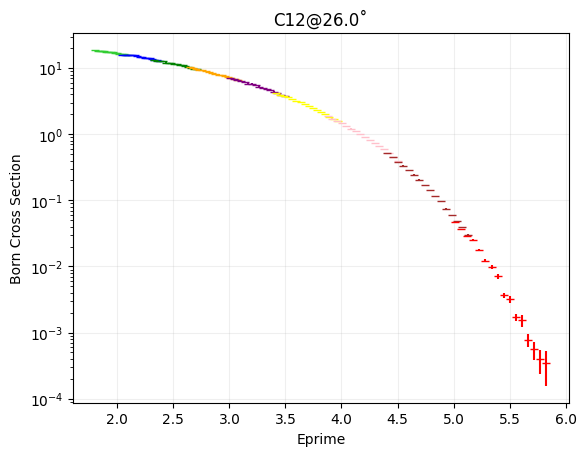

In [11]:
# Get points to interpolate based on angle and E'. Common for ntg and dtg
points_to_interpolate_1p95 = np.column_stack((binned_eprime_bin_centers_1p95, np.full(len(binned_eprime_bin_centers_1p95), dang)))
points_to_interpolate_2p21 = np.column_stack((binned_eprime_bin_centers_2p21, np.full(len(binned_eprime_bin_centers_2p21), dang)))
points_to_interpolate_2p52 = np.column_stack((binned_eprime_bin_centers_2p52, np.full(len(binned_eprime_bin_centers_2p52), dang)))
points_to_interpolate_2p86 = np.column_stack((binned_eprime_bin_centers_2p86, np.full(len(binned_eprime_bin_centers_2p86), dang)))
points_to_interpolate_3p25 = np.column_stack((binned_eprime_bin_centers_3p25, np.full(len(binned_eprime_bin_centers_3p25), dang)))
points_to_interpolate_3p69 = np.column_stack((binned_eprime_bin_centers_3p69, np.full(len(binned_eprime_bin_centers_3p69), dang)))
points_to_interpolate_4p19 = np.column_stack((binned_eprime_bin_centers_4p19, np.full(len(binned_eprime_bin_centers_4p19), dang)))
points_to_interpolate_4p767 = np.column_stack((binned_eprime_bin_centers_4p767, np.full(len(binned_eprime_bin_centers_4p767), dang)))
points_to_interpolate_5p42 = np.column_stack((binned_eprime_bin_centers_5p42, np.full(len(binned_eprime_bin_centers_5p42), dang)))

# Interpolate again to get model Born cross-section
born_xsec_array_1p95_ntg = griddata(points_ntg, V6, points_to_interpolate_1p95, method = 'linear')
born_xsec_array_2p21_ntg = griddata(points_ntg, V6, points_to_interpolate_2p21, method = 'linear')
born_xsec_array_2p52_ntg = griddata(points_ntg, V6, points_to_interpolate_2p52, method = 'linear')
born_xsec_array_2p86_ntg = griddata(points_ntg, V6, points_to_interpolate_2p86, method = 'linear')
born_xsec_array_3p25_ntg = griddata(points_ntg, V6, points_to_interpolate_3p25, method = 'linear')
born_xsec_array_3p69_ntg = griddata(points_ntg, V6, points_to_interpolate_3p69, method = 'linear')
born_xsec_array_4p19_ntg = griddata(points_ntg, V6, points_to_interpolate_4p19, method = 'linear')
born_xsec_array_4p767_ntg = griddata(points_ntg, V6, points_to_interpolate_4p767, method = 'linear')
born_xsec_array_5p42_ntg = griddata(points_ntg, V6, points_to_interpolate_5p42, method = 'linear')

# Get the QE piece
qe_array_1p95_ntg = griddata(points_ntg, V8, points_to_interpolate_1p95, method = 'linear')
qe_array_2p21_ntg = griddata(points_ntg, V8, points_to_interpolate_2p21, method = 'linear')
qe_array_2p52_ntg = griddata(points_ntg, V8, points_to_interpolate_2p52, method = 'linear')
qe_array_2p86_ntg = griddata(points_ntg, V8, points_to_interpolate_2p86, method = 'linear')
qe_array_3p25_ntg = griddata(points_ntg, V8, points_to_interpolate_3p25, method = 'linear')
qe_array_3p69_ntg = griddata(points_ntg, V8, points_to_interpolate_3p69, method = 'linear')
qe_array_4p19_ntg = griddata(points_ntg, V8, points_to_interpolate_4p19, method = 'linear')
qe_array_4p767_ntg = griddata(points_ntg, V8, points_to_interpolate_4p767, method = 'linear')
qe_array_5p42_ntg = griddata(points_ntg, V8, points_to_interpolate_5p42, method = 'linear')

# Interpolate 3rd time to get Coulomb correction factor
ccf_1p95_ntg = griddata(points_ntg, V13, points_to_interpolate_1p95, method = 'linear')
ccf_2p21_ntg = griddata(points_ntg, V13, points_to_interpolate_2p21, method = 'linear')
ccf_2p52_ntg = griddata(points_ntg, V13, points_to_interpolate_2p52, method = 'linear')
ccf_2p86_ntg = griddata(points_ntg, V13, points_to_interpolate_2p86, method = 'linear')
ccf_3p25_ntg = griddata(points_ntg, V13, points_to_interpolate_3p25, method = 'linear')
ccf_3p69_ntg = griddata(points_ntg, V13, points_to_interpolate_3p69, method = 'linear')
ccf_4p19_ntg = griddata(points_ntg, V13, points_to_interpolate_4p19, method = 'linear')
ccf_4p767_ntg = griddata(points_ntg, V13, points_to_interpolate_4p767, method = 'linear')
ccf_5p42_ntg = griddata(points_ntg, V13, points_to_interpolate_5p42, method = 'linear')

fig3, ax3 = plt.subplots()
# Calculate the data Born cross-section and apply Coloumb corrections
born_cross_1p95_ntg = ratio_eprime_1p95_ntg * born_xsec_array_1p95_ntg * ccf_1p95_ntg
born_cross_2p21_ntg = ratio_eprime_2p21_ntg * born_xsec_array_2p21_ntg * ccf_2p21_ntg
born_cross_2p52_ntg = ratio_eprime_2p52_ntg * born_xsec_array_2p52_ntg * ccf_2p52_ntg
born_cross_2p86_ntg = ratio_eprime_2p86_ntg * born_xsec_array_2p86_ntg * ccf_2p86_ntg
born_cross_3p25_ntg = ratio_eprime_3p25_ntg * born_xsec_array_3p25_ntg * ccf_3p25_ntg
born_cross_3p69_ntg = ratio_eprime_3p69_ntg * born_xsec_array_3p69_ntg * ccf_3p69_ntg
born_cross_4p19_ntg = ratio_eprime_4p19_ntg * born_xsec_array_4p19_ntg * ccf_4p19_ntg
born_cross_4p767_ntg = ratio_eprime_4p767_ntg * born_xsec_array_4p767_ntg * ccf_4p767_ntg
born_cross_5p42_ntg = ratio_eprime_5p42_ntg * born_xsec_array_5p42_ntg * ccf_5p42_ntg

# Calculate errors for born cross-sections
born_errors_1p95_ntg = born_cross_1p95_ntg * ratio_errors_1p95_ntg
born_errors_2p21_ntg = born_cross_2p21_ntg * ratio_errors_2p21_ntg
born_errors_2p52_ntg = born_cross_2p52_ntg * ratio_errors_2p52_ntg
born_errors_2p86_ntg = born_cross_2p86_ntg * ratio_errors_2p86_ntg
born_errors_3p25_ntg = born_cross_3p25_ntg * ratio_errors_3p25_ntg
born_errors_3p69_ntg = born_cross_3p69_ntg * ratio_errors_3p69_ntg
born_errors_4p19_ntg = born_cross_4p19_ntg * ratio_errors_4p19_ntg
born_errors_4p767_ntg = born_cross_4p767_ntg * ratio_errors_4p767_ntg
born_errors_5p42_ntg = born_cross_5p42_ntg * ratio_errors_5p42_ntg

# Plotting the born cross-sections with errors
ax3.errorbar(binned_eprime_bin_centers_1p95, born_cross_1p95_ntg, yerr=born_errors_1p95_ntg, fmt = '_', color = 'limegreen', label = '1.95 GeV')
ax3.errorbar(binned_eprime_bin_centers_2p21, born_cross_2p21_ntg, yerr=born_errors_2p21_ntg, fmt = '_', color = 'blue', label = '2.21 GeV')
ax3.errorbar(binned_eprime_bin_centers_2p52, born_cross_2p52_ntg, yerr=born_errors_2p52_ntg, fmt = '_', color = 'green', label = '2.52 GeV')
ax3.errorbar(binned_eprime_bin_centers_2p86, born_cross_2p86_ntg, yerr=born_errors_2p86_ntg, fmt = '_', color = 'orange', label = '2.86 GeV')
ax3.errorbar(binned_eprime_bin_centers_3p25, born_cross_3p25_ntg, yerr=born_errors_3p25_ntg, fmt = '_', color = 'purple', label = '3.25 GeV')
ax3.errorbar(binned_eprime_bin_centers_3p69, born_cross_3p69_ntg, yerr=born_errors_3p69_ntg, fmt = '_', color = 'yellow', label = '3.69 GeV')
ax3.errorbar(binned_eprime_bin_centers_4p19, born_cross_4p19_ntg, yerr=born_errors_4p19_ntg, fmt = '_', color = 'pink', label = '4.19 GeV')
ax3.errorbar(binned_eprime_bin_centers_4p767, born_cross_4p767_ntg, yerr=born_errors_4p767_ntg, fmt = '_', color = 'brown', label = '4.767 GeV')
ax3.errorbar(binned_eprime_bin_centers_5p42, born_cross_5p42_ntg, yerr=born_errors_5p42_ntg, fmt = '_', color = 'red', label = '5.42 GeV')
ax3.set_xlabel('Eprime')
ax3.set_ylabel('Born Cross Section')
ax3.set_title(f'{ntg}@{dang}˚')
ax3.set_yscale('log')
#ax3.legend()
ax3.grid(alpha = 0.2)
# fig3.savefig(f'{folder}/xsec_{ntg}_{dang}_{start_time:.0f}.pdf')

<h1 align="center">DATA WORK FOR DUMMY TARGET</h1>


In [12]:
E = 0.2165 # Mean of Ratio of upstream & downstream dummy to target cell thickness
acont_tg = ald + '_' + str(int(dang))
cont_dict_name = f'{acont_tg}_dict' # Dictionary containing the runs for the dummy
cont_dict = globals()[cont_dict_name]
Z, A = 13, 27 # Target
ytar_hist = {}

for momentum in dmom:
    # Get the runs where data for Dummy target was taken
    files = [f'/Volumes/smriti/xem2/ROOTfiles/HMS_{run}_skim.root' for run in cont_dict[momentum]]
    # Grab relevant bracnhes. ytar needed for upstream/downstream differentiation
    branches = ['H_gtr_dp', 'H_cal_etottracknorm', 'H_gtr_ph', 'H_gtr_th', 'H_cer_npeSum', 'H_bcm_CurrentFlag', 'H_gtr_y']
    electrons = uproot.concatenate(files, branches)

    data_cut = (np.abs(electrons['H_gtr_dp']) < 8) & (electrons['H_cal_etottracknorm'] > 0.7) & (np.abs(electrons['H_gtr_ph']) < 0.032) & (np.abs(electrons['H_gtr_th']) < 0.085) & (electrons['H_cer_npeSum'] > 2) & (electrons['H_bcm_CurrentFlag'] == 1)
    dp_cut = electrons['H_gtr_dp'][data_cut]
    theta_cut = electrons['H_gtr_th'][data_cut]
    phi_cut = electrons['H_gtr_ph'][data_cut]
    y_cut = electrons['H_gtr_y'][data_cut]

    theta_dict[momentum] = np.rad2deg(np.arccos((cos_ts + phi_cut * sin_ts)/np.sqrt(1 + theta_cut * theta_cut + phi_cut * phi_cut)))
    delta_hist[momentum] = np.array(dp_cut)
    ytar_hist[momentum] = np.array(y_cut)

dummy_eprime_bin_contents_1p63, dummy_eprime_bin_errors_1p63 = datahist_from_array(delta_hist[1.63], 1.63, hsdelta_binedges, acont_tg)
dummy_eprime_bin_contents_1p85, dummy_eprime_bin_errors_1p85 = datahist_from_array(delta_hist[1.85], 1.85, hsdelta_binedges, acont_tg)
dummy_eprime_bin_contents_2p11, dummy_eprime_bin_errors_2p11 = datahist_from_array(delta_hist[2.11], 2.11, hsdelta_binedges, acont_tg)
dummy_eprime_bin_contents_2p4, dummy_eprime_bin_errors_2p4 = datahist_from_array(delta_hist[2.4], 2.4, hsdelta_binedges, acont_tg)
dummy_eprime_bin_contents_2p72, dummy_eprime_bin_errors_2p72 = datahist_from_array(delta_hist[2.72], 2.72, hsdelta_binedges, acont_tg)
dummy_eprime_bin_contents_3p09, dummy_eprime_bin_errors_3p09 = datahist_from_array(delta_hist[3.09], 3.09, hsdelta_binedges, acont_tg)
dummy_eprime_bin_contents_3p57, dummy_eprime_bin_errors_3p57 = datahist_from_array(delta_hist[3.57], 3.57, hsdelta_binedges, acont_tg)
dummy_eprime_bin_contents_4p08, dummy_eprime_bin_errors_4p08 = datahist_from_array(delta_hist[4.08], 4.08, hsdelta_binedges, acont_tg)

plt.errorbar(binned_eprime_bin_centers_1p63, dummy_eprime_bin_contents_1p63, yerr=dummy_eprime_bin_errors_1p63, fmt='_', label='1.63 GeV', color='limegreen')
plt.errorbar(binned_eprime_bin_centers_1p85, dummy_eprime_bin_contents_1p85, yerr=dummy_eprime_bin_errors_1p85, fmt='_', label='1.85 GeV', color='blue')
plt.errorbar(binned_eprime_bin_centers_2p11, dummy_eprime_bin_contents_2p11, yerr=dummy_eprime_bin_errors_2p11, fmt='_', label='2.11 GeV', color='green')
plt.errorbar(binned_eprime_bin_centers_2p4, dummy_eprime_bin_contents_2p4, yerr=dummy_eprime_bin_errors_2p4, fmt='_', label='2.4 GeV', color='orange')
plt.errorbar(binned_eprime_bin_centers_2p72, dummy_eprime_bin_contents_2p72, yerr=dummy_eprime_bin_errors_2p72, fmt='_', label='2.72 GeV', color='purple')
plt.errorbar(binned_eprime_bin_centers_3p09, dummy_eprime_bin_contents_3p09, yerr=dummy_eprime_bin_errors_3p09, fmt='_', label='3.09 GeV', color='yellow')
plt.errorbar(binned_eprime_bin_centers_3p57, dummy_eprime_bin_contents_3p57, yerr=dummy_eprime_bin_errors_3p57, fmt='_', label='3.57 GeV', color='pink')
plt.errorbar(binned_eprime_bin_centers_4p08, dummy_eprime_bin_contents_4p08, yerr=dummy_eprime_bin_errors_4p08, fmt='_', label='4.08 GeV', color='brown')
plt.grid(alpha=0.2)
plt.grid(alpha = 0.2)
plt.xlabel('E\'')
plt.ylabel('Data Yield for Dummy Target')
plt.title(f'Full {ald} Yield {dang}˚')
plt.yscale('log')

NameError: name 'hsdelta_binedges' is not defined

<h1 align="center">DATA WORK FOR DTG</h1>

In [13]:
# Kinematic variables
Z, A = target_info[dtg][0], target_info[dtg][1]  # Target
thick = target_info[dtg][2] # g/cm2. From Cameron's target sheet column 'R'
thick = thick * 0.996 # Cryo target contraction correction factor
lumin = thick * sim_charge / A * N_A / Q_E * 1e-39
ytar = {}
ytar_hist = {}
delta_hist = {}
eff_weight = {}
dtg_dict_name = f'{adtg}_dict'
dtg_dict = globals()[target_dict_name]

for momentum in dmom:
    files = [f'/Volumes/smriti/xem2/ROOTfiles/HMS_{run}_skim.root' for run in dtg_dict[momentum]]
    branches = ['H_gtr_dp', 'H_cal_etottracknorm', 'H_gtr_ph', 'H_gtr_th', 'H_cer_npeSum', 'H_bcm_CurrentFlag']
    electrons = uproot.concatenate(files, branches)

    data_cut = (np.abs(electrons['H_gtr_dp']) < 8) & (electrons['H_cal_etottracknorm'] > 0.7) & (np.abs(electrons['H_gtr_ph']) < 0.032) & (np.abs(electrons['H_gtr_th']) < 0.085) & (electrons['H_cer_npeSum'] > 2) & (electrons['H_bcm_CurrentFlag'] == 1)
    dp_cut = electrons['H_gtr_dp'][data_cut]

    # Cherenkov efficiency correction
    eff_weight[momentum] = 1 / cereff(dp_cut)
    delta_hist[momentum] = np.array(dp_cut)

eprime_bin_contents_1p95_dtg, eprime_bin_errors_1p95_dtg = datahist_from_array(delta_hist[1.95], 1.95, data_delta, adtg, eff_weight[1.95])
eprime_bin_contents_2p21_dtg, eprime_bin_errors_2p21_dtg = datahist_from_array(delta_hist[2.21], 2.21, data_delta, adtg, eff_weight[2.21])
eprime_bin_contents_2p52_dtg, eprime_bin_errors_2p52_dtg = datahist_from_array(delta_hist[2.52], 2.52, data_delta, adtg, eff_weight[2.52])
eprime_bin_contents_2p86_dtg, eprime_bin_errors_2p86_dtg = datahist_from_array(delta_hist[2.86], 2.86, data_delta, adtg, eff_weight[2.86])
eprime_bin_contents_3p25_dtg, eprime_bin_errors_3p25_dtg = datahist_from_array(delta_hist[3.25], 3.25, data_delta, adtg, eff_weight[3.25])
eprime_bin_contents_3p69_dtg, eprime_bin_errors_3p69_dtg = datahist_from_array(delta_hist[3.69], 3.69, data_delta, adtg, eff_weight[3.69])
eprime_bin_contents_4p19_dtg, eprime_bin_errors_4p19_dtg = datahist_from_array(delta_hist[4.19], 4.19, data_delta, adtg, eff_weight[4.19])
eprime_bin_contents_4p767_dtg, eprime_bin_errors_4p767_dtg = datahist_from_array(delta_hist[4.767], 4.767, data_delta, adtg, eff_weight[4.767])
eprime_bin_contents_5p42_dtg, eprime_bin_errors_5p42_dtg = datahist_from_array(delta_hist[5.42], 5.42, data_delta, adtg, eff_weight[5.42])

Target boiling correction not applied for cryo target LD2_26
Scaling factor for LD2_26 at 1.95 GeV/c is 2.530994257535107e-05
Yield for LD2_26 at 1.95 GeV/c is [5.78309648 5.57634206 5.47002713 5.39212701 5.30164029 5.2578278
 5.18744925 5.10867082 5.02903642 4.92156686 4.86732401 4.73195825
 4.62695323 4.51381815 4.37199913 4.28980915]
Target boiling correction not applied for cryo target LD2_26
Scaling factor for LD2_26 at 2.21 GeV/c is 0.00012782460363971698
Yield for LD2_26 at 2.21 GeV/c is [1.60030162 1.57165172 1.52931638 1.5033524  1.49235289 1.49196918
 1.45973804 1.42736091 1.39167147 1.3462515  1.343172   1.33226547
 1.26862262 1.22499648 1.22358504 1.18278177]
Target boiling correction not applied for cryo target LD2_26
Scaling factor for LD2_26 at 2.52 GeV/c is 6.116379354168462e-05
Yield for LD2_26 at 2.52 GeV/c is [0.92045573 0.87945138 0.8579088  0.86176444 0.81916888 0.80007432
 0.79976831 0.78793114 0.77603374 0.7650079  0.7395895  0.71865309
 0.70084793 0.67278945 0.6

Target boiling correction not applied for cryo target LD2_26
Target boiling correction not applied for cryo target LD2_26


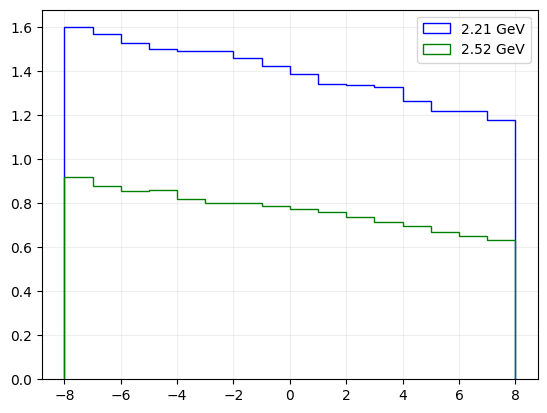

In [14]:
plt.hist(delta_hist[2.21], bins = data_delta, histtype = 'step', label = '2.21 GeV', color = 'blue', weights = np.ones_like(delta_hist[2.21]) * read_report(2.21, adtg))
plt.hist(delta_hist[2.52], bins = data_delta, histtype = 'step', label = '2.52 GeV', color = 'green', weights = np.ones_like(delta_hist[2.52]) * read_report(2.52, adtg))
# plt.hist(delta_hist[2.21], bins = data_delta, histtype = 'step', label = '2.21 GeV', color = 'blue')
# plt.hist(delta_hist[2.52], bins = data_delta, histtype = 'step', label = '2.52 GeV', color = 'green')
plt.grid(alpha = 0.2)
plt.legend()

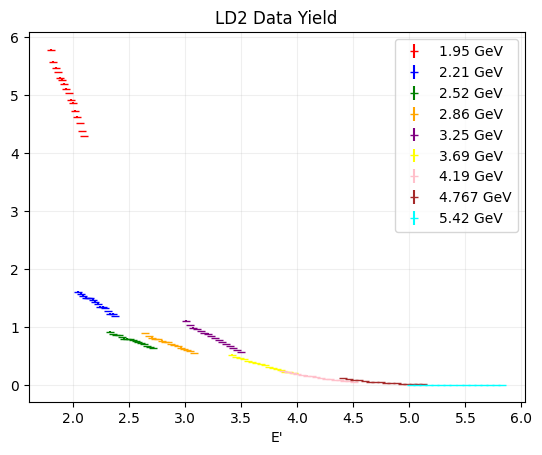

In [15]:
fig3, ax3 = plt.subplots()
ax3.errorbar(binned_eprime_bin_centers_1p95, eprime_bin_contents_1p95_dtg, yerr = eprime_bin_errors_1p95_dtg, fmt = '_', color = 'red', label = '1.95 GeV')
ax3.errorbar(binned_eprime_bin_centers_2p21, eprime_bin_contents_2p21_dtg, yerr = eprime_bin_errors_2p21_dtg, fmt = '_', color = 'blue', label = '2.21 GeV')
ax3.errorbar(binned_eprime_bin_centers_2p52, eprime_bin_contents_2p52_dtg, yerr = eprime_bin_errors_2p52_dtg, fmt = '_', color = 'green', label = '2.52 GeV')
ax3.errorbar(binned_eprime_bin_centers_2p86, eprime_bin_contents_2p86_dtg, yerr = eprime_bin_errors_2p86_dtg, fmt = '_', color = 'orange', label = '2.86 GeV')
ax3.errorbar(binned_eprime_bin_centers_3p25, eprime_bin_contents_3p25_dtg, yerr = eprime_bin_errors_3p25_dtg, fmt = '_', color = 'purple', label = '3.25 GeV')
ax3.errorbar(binned_eprime_bin_centers_3p69, eprime_bin_contents_3p69_dtg, yerr = eprime_bin_errors_3p69_dtg, fmt = '_', color = 'yellow', label = '3.69 GeV')
ax3.errorbar(binned_eprime_bin_centers_4p19, eprime_bin_contents_4p19_dtg, yerr = eprime_bin_errors_4p19_dtg, fmt = '_', color = 'pink', label = '4.19 GeV')
ax3.errorbar(binned_eprime_bin_centers_4p767, eprime_bin_contents_4p767_dtg, yerr = eprime_bin_errors_4p767_dtg, fmt = '_', color = 'brown', label = '4.767 GeV')
ax3.errorbar(binned_eprime_bin_centers_5p42, eprime_bin_contents_5p42_dtg, yerr = eprime_bin_errors_5p42_dtg, fmt = '_', color = 'cyan', label = '5.42 GeV')
ax3.set_xlabel('E\'')
ax3.legend()
# ax3.set_yscale('log')
ax3.set_title(f'LD2@{dang} Data Yield')
ax3.grid(alpha = 0.2)
# fig3.savefig(f'{folder}/data_yield_{dtg}_{dang}_{start_time:.0f}.pdf')

<h2 style="text-align: center; color: silver">Subtracting CSB from full cryo target yield and dummy</h2>

Text(0.5, 1.0, 'Dummy Subtracted LD2 Data Yield')

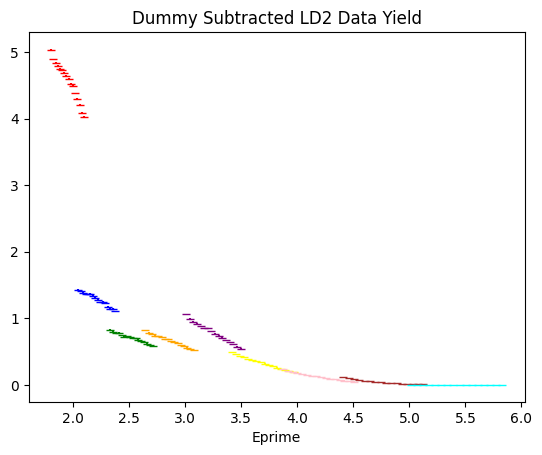

In [16]:
# Calculate the charge symmetric background fraction per bin for full cryo target
csb_frac_1p95_dtg = csb(binned_eprime_bin_centers_1p95, dtg, dang)
csb_frac_2p21_dtg = csb(binned_eprime_bin_centers_2p21, dtg, dang)
csb_frac_2p52_dtg = csb(binned_eprime_bin_centers_2p52, dtg, dang)
csb_frac_2p86_dtg = csb(binned_eprime_bin_centers_2p86, dtg, dang)
csb_frac_3p25_dtg = csb(binned_eprime_bin_centers_3p25, dtg, dang)
csb_frac_3p69_dtg = csb(binned_eprime_bin_centers_3p69, dtg, dang)
csb_frac_4p19_dtg = csb(binned_eprime_bin_centers_4p19, dtg, dang)
csb_frac_4p767_dtg = csb(binned_eprime_bin_centers_4p767, dtg, dang)
csb_frac_5p42_dtg = csb(binned_eprime_bin_centers_5p42, dtg, dang)

# Calculate the charge symmetric background fraction per bin for dummy target
csb_frac_1p95_ald = csb(binned_eprime_bin_centers_1p95, ald, dang)
csb_frac_2p21_ald = csb(binned_eprime_bin_centers_2p21, ald, dang)
csb_frac_2p52_ald = csb(binned_eprime_bin_centers_2p52, ald, dang)
csb_frac_2p86_ald = csb(binned_eprime_bin_centers_2p86, ald, dang)
csb_frac_3p25_ald = csb(binned_eprime_bin_centers_3p25, ald, dang)
csb_frac_3p69_ald = csb(binned_eprime_bin_centers_3p69, ald, dang)
csb_frac_4p19_ald = csb(binned_eprime_bin_centers_4p19, ald, dang)
csb_frac_4p767_ald = csb(binned_eprime_bin_centers_4p767, ald, dang)
csb_frac_5p42_ald = csb(binned_eprime_bin_centers_5p42, ald, dang)

fig4, ax4 = plt.subplots()
# Perform CSB subtraction on dummy target
subtracted_bin_contents_1p95_ald = dummy_eprime_bin_contents_1p95 * (1 - csb_frac_1p95_ald)
subtracted_bin_contents_2p21_ald = dummy_eprime_bin_contents_2p21 * (1 - csb_frac_2p21_ald)
subtracted_bin_contents_2p52_ald = dummy_eprime_bin_contents_2p52 * (1 - csb_frac_2p52_ald)
subtracted_bin_contents_2p86_ald = dummy_eprime_bin_contents_2p86 * (1 - csb_frac_2p86_ald)
subtracted_bin_contents_3p25_ald = dummy_eprime_bin_contents_3p25 * (1 - csb_frac_3p25_ald)
subtracted_bin_contents_3p69_ald = dummy_eprime_bin_contents_3p69 * (1 - csb_frac_3p69_ald)
subtracted_bin_contents_4p19_ald = dummy_eprime_bin_contents_4p19 * (1 - csb_frac_4p19_ald)
subtracted_bin_contents_4p767_ald = dummy_eprime_bin_contents_4p767 * (1 - csb_frac_4p767_ald)
subtracted_bin_contents_5p42_ald = dummy_eprime_bin_contents_5p42 * (1 - csb_frac_5p42_ald)

subtracted_bin_errors_1p95_ald = dummy_eprime_bin_errors_1p95 * (1 - csb_frac_1p95_ald)
subtracted_bin_errors_2p21_ald = dummy_eprime_bin_errors_2p21 * (1 - csb_frac_2p21_ald)
subtracted_bin_errors_2p52_ald = dummy_eprime_bin_errors_2p52 * (1 - csb_frac_2p52_ald)
subtracted_bin_errors_2p86_ald = dummy_eprime_bin_errors_2p86 * (1 - csb_frac_2p86_ald)
subtracted_bin_errors_3p25_ald = dummy_eprime_bin_errors_3p25 * (1 - csb_frac_3p25_ald)
subtracted_bin_errors_3p69_ald = dummy_eprime_bin_errors_3p69 * (1 - csb_frac_3p69_ald)
subtracted_bin_errors_4p19_ald = dummy_eprime_bin_errors_4p19 * (1 - csb_frac_4p19_ald)
subtracted_bin_errors_4p767_ald = dummy_eprime_bin_errors_4p767 * (1 - csb_frac_4p767_ald)
subtracted_bin_errors_5p42_ald = dummy_eprime_bin_errors_5p42 * (1 - csb_frac_5p42_ald)

# Subtract the charge symmetric background fraction from the full cryo yield
subtracted_bin_contents_1p95_dtg = eprime_bin_contents_1p95_dtg * (1 - csb_frac_1p95_dtg)
subtracted_bin_contents_2p21_dtg = eprime_bin_contents_2p21_dtg * (1 - csb_frac_2p21_dtg)
subtracted_bin_contents_2p52_dtg = eprime_bin_contents_2p52_dtg * (1 - csb_frac_2p52_dtg)
subtracted_bin_contents_2p86_dtg = eprime_bin_contents_2p86_dtg * (1 - csb_frac_2p86_dtg)
subtracted_bin_contents_3p25_dtg = eprime_bin_contents_3p25_dtg * (1 - csb_frac_3p25_dtg)
subtracted_bin_contents_3p69_dtg = eprime_bin_contents_3p69_dtg * (1 - csb_frac_3p69_dtg)
subtracted_bin_contents_4p19_dtg = eprime_bin_contents_4p19_dtg * (1 - csb_frac_4p19_dtg)
subtracted_bin_contents_4p767_dtg = eprime_bin_contents_4p767_dtg * (1 - csb_frac_4p767_dtg)
subtracted_bin_contents_5p42_dtg = eprime_bin_contents_5p42_dtg * (1 - csb_frac_5p42_dtg)

subtracted_bin_errors_1p95_dtg = eprime_bin_errors_1p95_dtg * (1 - csb_frac_1p95_dtg)
subtracted_bin_errors_2p21_dtg = eprime_bin_errors_2p21_dtg * (1 - csb_frac_2p21_dtg)
subtracted_bin_errors_2p52_dtg = eprime_bin_errors_2p52_dtg * (1 - csb_frac_2p52_dtg)
subtracted_bin_errors_2p86_dtg = eprime_bin_errors_2p86_dtg * (1 - csb_frac_2p86_dtg)
subtracted_bin_errors_3p25_dtg = eprime_bin_errors_3p25_dtg * (1 - csb_frac_3p25_dtg)
subtracted_bin_errors_3p69_dtg = eprime_bin_errors_3p69_dtg * (1 - csb_frac_3p69_dtg)
subtracted_bin_errors_4p19_dtg = eprime_bin_errors_4p19_dtg * (1 - csb_frac_4p19_dtg)
subtracted_bin_errors_4p767_dtg = eprime_bin_errors_4p767_dtg * (1 - csb_frac_4p767_dtg)
subtracted_bin_errors_5p42_dtg = eprime_bin_errors_5p42_dtg * (1 - csb_frac_5p42_dtg)

# Perform Dummy Subtraction
subtracted_bin_contents_1p95_dtg = subtracted_bin_contents_1p95_dtg - (E * subtracted_bin_contents_1p95_ald)
subtracted_bin_contents_2p21_dtg = subtracted_bin_contents_2p21_dtg - (E * subtracted_bin_contents_2p21_ald)
subtracted_bin_contents_2p52_dtg = subtracted_bin_contents_2p52_dtg - (E * subtracted_bin_contents_2p52_ald)
subtracted_bin_contents_2p86_dtg = subtracted_bin_contents_2p86_dtg - (E * subtracted_bin_contents_2p86_ald)
subtracted_bin_contents_3p25_dtg = subtracted_bin_contents_3p25_dtg - (E * subtracted_bin_contents_3p25_ald)
subtracted_bin_contents_3p69_dtg = subtracted_bin_contents_3p69_dtg - (E * subtracted_bin_contents_3p69_ald)
subtracted_bin_contents_4p19_dtg = subtracted_bin_contents_4p19_dtg - (E * subtracted_bin_contents_4p19_ald)
subtracted_bin_contents_4p767_dtg = subtracted_bin_contents_4p767_dtg - (E * subtracted_bin_contents_4p767_ald)
subtracted_bin_contents_5p42_dtg = subtracted_bin_contents_5p42_dtg - (E * subtracted_bin_contents_5p42_ald)

# Error Propagation
eprime_bin_errors_1p95_dtg = np.sqrt((subtracted_bin_errors_1p95_dtg)**2 + (E * subtracted_bin_errors_1p95_ald)**2)
eprime_bin_errors_2p21_dtg = np.sqrt((subtracted_bin_errors_2p21_dtg)**2 + (E * subtracted_bin_errors_2p21_ald)**2)
eprime_bin_errors_2p52_dtg = np.sqrt((subtracted_bin_errors_2p52_dtg)**2 + (E * subtracted_bin_errors_2p52_ald)**2)
eprime_bin_errors_2p86_dtg = np.sqrt((subtracted_bin_errors_2p86_dtg)**2 + (E * subtracted_bin_errors_2p86_ald)**2)
eprime_bin_errors_3p25_dtg = np.sqrt((subtracted_bin_errors_3p25_dtg)**2 + (E * subtracted_bin_errors_3p25_ald)**2)
eprime_bin_errors_3p69_dtg = np.sqrt((subtracted_bin_errors_3p69_dtg)**2 + (E * subtracted_bin_errors_3p69_ald)**2)
eprime_bin_errors_4p19_dtg = np.sqrt((subtracted_bin_errors_4p19_dtg)**2 + (E * subtracted_bin_errors_4p19_ald)**2)
eprime_bin_errors_4p767_dtg = np.sqrt((subtracted_bin_errors_4p767_dtg)**2 + (E * subtracted_bin_errors_4p767_ald)**2)
eprime_bin_errors_5p42_dtg = np.sqrt((subtracted_bin_errors_5p42_dtg)**2 + (E * subtracted_bin_errors_5p42_ald)**2)

ax4.errorbar(binned_eprime_bin_centers_1p95, subtracted_bin_contents_1p95_dtg, yerr = subtracted_bin_errors_1p95_dtg, fmt = '_', color = 'red', label = '1.95 GeV')
ax4.errorbar(binned_eprime_bin_centers_2p21, subtracted_bin_contents_2p21_dtg, yerr = subtracted_bin_errors_2p21_dtg, fmt = '_', color = 'blue', label = '2.21 GeV')
ax4.errorbar(binned_eprime_bin_centers_2p52, subtracted_bin_contents_2p52_dtg, yerr = subtracted_bin_errors_2p52_dtg, fmt = '_', color = 'green', label = '2.52 GeV')
ax4.errorbar(binned_eprime_bin_centers_2p86, subtracted_bin_contents_2p86_dtg, yerr = subtracted_bin_errors_2p86_dtg, fmt = '_', color = 'orange', label = '2.86 GeV')
ax4.errorbar(binned_eprime_bin_centers_3p25, subtracted_bin_contents_3p25_dtg, yerr = subtracted_bin_errors_3p25_dtg, fmt = '_', color = 'purple', label = '3.25 GeV')
ax4.errorbar(binned_eprime_bin_centers_3p69, subtracted_bin_contents_3p69_dtg, yerr = subtracted_bin_errors_3p69_dtg, fmt = '_', color = 'yellow', label = '3.69 GeV')
ax4.errorbar(binned_eprime_bin_centers_4p19, subtracted_bin_contents_4p19_dtg, yerr = subtracted_bin_errors_4p19_dtg, fmt = '_', color = 'pink', label = '4.19 GeV')
ax4.errorbar(binned_eprime_bin_centers_4p767, subtracted_bin_contents_4p767_dtg, yerr = subtracted_bin_errors_4p767_dtg, fmt = '_', color = 'brown', label = '4.767 GeV')
ax4.errorbar(binned_eprime_bin_centers_5p42, subtracted_bin_contents_5p42_dtg, yerr = subtracted_bin_errors_5p42_dtg, fmt = '_', color = 'cyan', label = '5.42 GeV')
ax4.set_xlabel('Eprime')
ax4.set_title('Dummy Subtracted LD2 Data Yield')

<h1 align="center">SIMULATION WORK FOR DTG</h1>


In [18]:
# Read the Cross-section table
V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13 = ImportRadcor("/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/xem2/xsec_tables/xem2_emc_rc_d2cryo22_hms.out")

# If using the old mc files
# dpp_up, dpp_down = 15.0, -15.0 # Momentum acceptance upper and lower limit
# for momentum in dmom:
#     ep_min[momentum] = momentum * (1 + 0.01 * dpp_down)
#     ep_max[momentum] = momentum * (1 + 0.01 * dpp_up)
#     phi_up, phi_down, theta_up, theta_down = 110.0, -110.0, 65.0, -65.0 # mrad
#     domega = (phi_up - phi_down) * (theta_up - theta_down) / 1e6  # diff solid angle in sr
#     sim_charge = 1.
#     wall_exit, wall_ent = 0.0168, 0.02024 # in cm
#     dum_thick_exit, dum_thick_ent = 0.1816, 0.1815 # g/cm2
#     lumin = thick * sim_charge / A * N_A / Q_E * 1e-39

ytar_weight = {}
ytarcut = {}
jacobian_weight = {}
for momentum in dmom:
    mom_str = str(momentum).replace('-', '').replace('.', 'p').rstrip('0')
    # filepath = f"/Volumes/smriti/xem2/worksim_old/hms_mc_{dsimstring}_20degm{mom_str}.root"
    filepath = f"/Volumes/smriti/xem2/worksim/hms_{idang}deg_{mom_str}gev_{dsimstring}.root"

    # Open the file and tree
    file = uproot.open(filepath)
    # tree = file["h1"]
    tree = file["h10"]

    # Load the branches
    electrons = tree.arrays(["hsdeltai", "hsytar", "hsyptari", "hsxptari", "stop_id"], library = 'np')    
    nentries = len(electrons["hsdeltai"])

    # Apply the cuts
    mc_cut = (np.abs(electrons["hsdeltai"]) < 8) & \
            (np.abs(electrons["hsyptari"]) < 0.032) & \
            (np.abs(electrons["hsxptari"]) < 0.085) & \
            (electrons["stop_id"] == 0)
    
    # Filter 'hsdelta' with the cuts
    hsdelta_cut = electrons["hsdeltai"][mc_cut]
    hsyptar_cut = electrons["hsyptari"][mc_cut]
    hsxptar_cut = electrons["hsxptari"][mc_cut]
    hsytar_cut = electrons["hsytar"][mc_cut]

    delta_dict[momentum] = hsdelta_cut
    Eprime_dict[momentum] = momentum * (1 + 0.01 * hsdelta_cut)

    delta_weight[momentum] = delta_correction(hsdelta_cut)

    # Calculate the ytar acceptance correction factor
    ytar_weight[momentum] = -0.00812174 * hsytar_cut**2 - 0.0000415678 * hsytar_cut + 1.00021
    ytarcut[momentum] = hsytar_cut

    # MC Jacobian
    jacobian_weight[momentum] = np.power((1 + np.power(hsxptar_cut, 2) + np.power(hsyptar_cut, 2)), 1.5)

    # print("Length of ytar_weight", len(ytar_weight))
    # print("Length of Eprime_dict", len(Eprime_dict[momentum]))
    
    # Calculate theta (in degrees)
    thetarad = np.arccos((cos_ts + hsyptar_cut * sin_ts) / np.sqrt(1 + hsxptar_cut * hsxptar_cut + hsyptar_cut * hsyptar_cut))
    thetadeg = np.rad2deg(thetarad)
    
    # Perform the interpolation
    points_dtg = np.array([V2, V3]).T # Make a 2D array and transpose it so each array is of the form [E',theta]
    points_to_interpolate = np.column_stack((Eprime_dict[momentum], thetadeg))  # Make a column stack of points to be interpolated for our given E' and theta
    xsec_array[momentum] = griddata(points_dtg, V9, points_to_interpolate, method = 'linear') # Specify the 2D array of [E's, thetas] as first argument; Radiative cross-section(V9) as the z-axis and (Ep, theta) as the point for which we need the cross-section
    mc_scale[momentum] = lumin * domega * (ep_max[momentum] - ep_min[momentum]) / nentries         # Calculate the scale for simulation

# Determine hsdelta_min and hsdelta_max based on the delta_dict for the first value in dmom
hsdelta_min, hsdelta_max = np.min(delta_dict[1.95]), np.max(delta_dict[1.95])
print("Should be -8 and +8", hsdelta_min, hsdelta_max)
hsdelta_num_bins = bin_per_mom
hsdelta_binedges = np.linspace(hsdelta_min, hsdelta_max, hsdelta_num_bins + 1)

# Update the mchist_from_array function calls with new dmom values
bin_counts_eprime_1p95_dtg, bin_errors_eprime_1p95_dtg = mchist_from_array(delta_dict[1.95], xsec_array[1.95] * mc_scale[1.95] * ytar_weight[1.95] * jacobian_weight[1.95] * delta_weight[1.95], hsdelta_binedges)
bin_counts_eprime_2p21_dtg, bin_errors_eprime_2p21_dtg = mchist_from_array(delta_dict[2.21], xsec_array[2.21] * mc_scale[2.21] * ytar_weight[2.21] * jacobian_weight[2.21] * delta_weight[2.21], hsdelta_binedges)
bin_counts_eprime_2p52_dtg, bin_errors_eprime_2p52_dtg = mchist_from_array(delta_dict[2.52], xsec_array[2.52] * mc_scale[2.52] * ytar_weight[2.52] * jacobian_weight[2.52] * delta_weight[2.52], hsdelta_binedges)
bin_counts_eprime_2p86_dtg, bin_errors_eprime_2p86_dtg = mchist_from_array(delta_dict[2.86], xsec_array[2.86] * mc_scale[2.86] * ytar_weight[2.86] * jacobian_weight[2.86] * delta_weight[2.86], hsdelta_binedges)
bin_counts_eprime_3p25_dtg, bin_errors_eprime_3p25_dtg = mchist_from_array(delta_dict[3.25], xsec_array[3.25] * mc_scale[3.25] * ytar_weight[3.25] * jacobian_weight[3.25] * delta_weight[3.25], hsdelta_binedges)
bin_counts_eprime_3p69_dtg, bin_errors_eprime_3p69_dtg = mchist_from_array(delta_dict[3.69], xsec_array[3.69] * mc_scale[3.69] * ytar_weight[3.69] * jacobian_weight[3.69] * delta_weight[3.69], hsdelta_binedges)
bin_counts_eprime_4p19_dtg, bin_errors_eprime_4p19_dtg = mchist_from_array(delta_dict[4.19], xsec_array[4.19] * mc_scale[4.19] * ytar_weight[4.19] * jacobian_weight[4.19] * delta_weight[4.19], hsdelta_binedges)
bin_counts_eprime_4p767_dtg, bin_errors_eprime_4p767_dtg = mchist_from_array(delta_dict[4.767], xsec_array[4.767] * mc_scale[4.767] * ytar_weight[4.767] * jacobian_weight[4.767] * delta_weight[4.767], hsdelta_binedges)
bin_counts_eprime_5p42_dtg, bin_errors_eprime_5p42_dtg = mchist_from_array(delta_dict[5.42], xsec_array[5.42] * mc_scale[5.42] * ytar_weight[5.42] * jacobian_weight[5.42] * delta_weight[5.42], hsdelta_binedges)

Should be -8 and +8 -7.999983038287606 7.999998367857188


Text(0.5, 1.0, 'LD2@26.0˚')

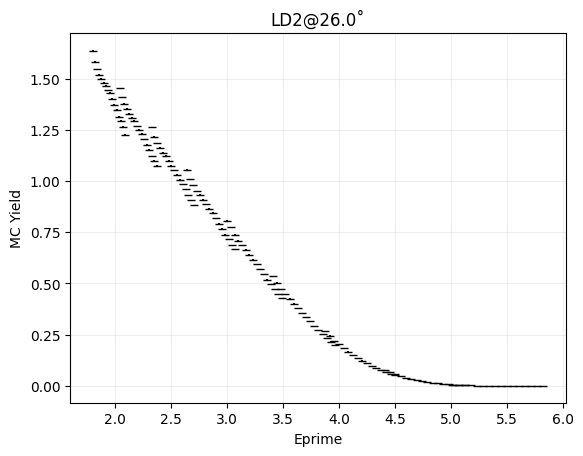

In [19]:
fig4, ax4 = plt.subplots()
ax4.errorbar(binned_eprime_bin_centers_1p95, bin_counts_eprime_1p95_dtg, yerr = bin_errors_eprime_1p95_dtg, fmt = '_', color = 'black', label = 'Sim 1.95 GeV')
ax4.errorbar(binned_eprime_bin_centers_2p21, bin_counts_eprime_2p21_dtg, yerr = bin_errors_eprime_2p21_dtg, fmt = '_', color = 'black', label = 'Sim 2.21 GeV')
ax4.errorbar(binned_eprime_bin_centers_2p52, bin_counts_eprime_2p52_dtg, yerr = bin_errors_eprime_2p52_dtg, fmt = '_', color = 'black', label = 'Sim 2.52 GeV')
ax4.errorbar(binned_eprime_bin_centers_2p86, bin_counts_eprime_2p86_dtg, yerr = bin_errors_eprime_2p86_dtg, fmt = '_', color = 'black', label = 'Sim 2.86 GeV')
ax4.errorbar(binned_eprime_bin_centers_3p25, bin_counts_eprime_3p25_dtg, yerr = bin_errors_eprime_3p25_dtg, fmt = '_', color = 'black', label = 'Sim 3.25 GeV')
ax4.errorbar(binned_eprime_bin_centers_3p69, bin_counts_eprime_3p69_dtg, yerr = bin_errors_eprime_3p69_dtg, fmt = '_', color = 'black', label = 'Sim 3.69 GeV')
ax4.errorbar(binned_eprime_bin_centers_4p19, bin_counts_eprime_4p19_dtg, yerr = bin_errors_eprime_4p19_dtg, fmt = '_', color = 'black', label = 'Sim 4.19 GeV')
ax4.errorbar(binned_eprime_bin_centers_4p767, bin_counts_eprime_4p767_dtg, yerr = bin_errors_eprime_4p767_dtg, fmt = '_', color = 'black', label = 'Sim 4.767 GeV')
ax4.errorbar(binned_eprime_bin_centers_5p42, bin_counts_eprime_5p42_dtg, yerr = bin_errors_eprime_5p42_dtg, fmt = '_', color = 'black', label = 'Sim 5.42 GeV')
ax4.grid(alpha = 0.2)
ax4.set_xlabel('Eprime')
ax4.set_ylabel('MC Yield')
# ax4.set_yscale('log')
# ax4.legend() 
ax4.set_title(f'{dtg}@{dang}˚')
# fig4.savefig(f'{folder}/eprime_{dtg}_{dang}_{start_time:.0f}.pdf')

<h1 align="center">DATA/SIMULATION YIELD RATIO FOR DTG</h1>

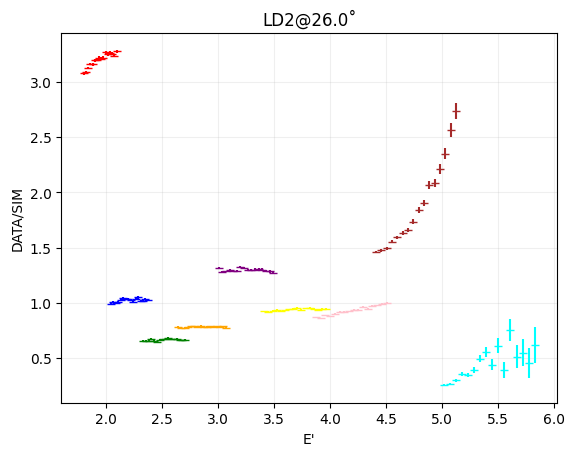

In [20]:
# Calculating the ratio of data to simulation and associated errors for each momentum value
ratio_eprime_1p95_dtg = subtracted_bin_contents_1p95_dtg / bin_counts_eprime_1p95_dtg
ratio_eprime_2p21_dtg = subtracted_bin_contents_2p21_dtg / bin_counts_eprime_2p21_dtg
ratio_eprime_2p52_dtg = subtracted_bin_contents_2p52_dtg / bin_counts_eprime_2p52_dtg
ratio_eprime_2p86_dtg = subtracted_bin_contents_2p86_dtg / bin_counts_eprime_2p86_dtg
ratio_eprime_3p25_dtg = subtracted_bin_contents_3p25_dtg / bin_counts_eprime_3p25_dtg
ratio_eprime_3p69_dtg = subtracted_bin_contents_3p69_dtg / bin_counts_eprime_3p69_dtg
ratio_eprime_4p19_dtg = subtracted_bin_contents_4p19_dtg / bin_counts_eprime_4p19_dtg
ratio_eprime_4p767_dtg = subtracted_bin_contents_4p767_dtg / bin_counts_eprime_4p767_dtg
ratio_eprime_5p42_dtg = subtracted_bin_contents_5p42_dtg / bin_counts_eprime_5p42_dtg

# Add errors in quadrature for each momentum value
ratio_errors_1p95_dtg = ratio_eprime_1p95_dtg * np.sqrt((subtracted_bin_errors_1p95_dtg / subtracted_bin_contents_1p95_dtg)**2 + (bin_errors_eprime_1p95_dtg / bin_counts_eprime_1p95_dtg)**2)
ratio_errors_2p21_dtg = ratio_eprime_2p21_dtg * np.sqrt((subtracted_bin_errors_2p21_dtg / subtracted_bin_contents_2p21_dtg)**2 + (bin_errors_eprime_2p21_dtg / bin_counts_eprime_2p21_dtg)**2)
ratio_errors_2p52_dtg = ratio_eprime_2p52_dtg * np.sqrt((subtracted_bin_errors_2p52_dtg / subtracted_bin_contents_2p52_dtg)**2 + (bin_errors_eprime_2p52_dtg / bin_counts_eprime_2p52_dtg)**2)
ratio_errors_2p86_dtg = ratio_eprime_2p86_dtg * np.sqrt((subtracted_bin_errors_2p86_dtg / subtracted_bin_contents_2p86_dtg)**2 + (bin_errors_eprime_2p86_dtg / bin_counts_eprime_2p86_dtg)**2)
ratio_errors_3p25_dtg = ratio_eprime_3p25_dtg * np.sqrt((subtracted_bin_errors_3p25_dtg / subtracted_bin_contents_3p25_dtg)**2 + (bin_errors_eprime_3p25_dtg / bin_counts_eprime_3p25_dtg)**2)
ratio_errors_3p69_dtg = ratio_eprime_3p69_dtg * np.sqrt((subtracted_bin_errors_3p69_dtg / subtracted_bin_contents_3p69_dtg)**2 + (bin_errors_eprime_3p69_dtg / bin_counts_eprime_3p69_dtg)**2)
ratio_errors_4p19_dtg = ratio_eprime_4p19_dtg * np.sqrt((subtracted_bin_errors_4p19_dtg / subtracted_bin_contents_4p19_dtg)**2 + (bin_errors_eprime_4p19_dtg / bin_counts_eprime_4p19_dtg)**2)
ratio_errors_4p767_dtg = ratio_eprime_4p767_dtg * np.sqrt((subtracted_bin_errors_4p767_dtg / subtracted_bin_contents_4p767_dtg)**2 + (bin_errors_eprime_4p767_dtg / bin_counts_eprime_4p767_dtg)**2)
ratio_errors_5p42_dtg = ratio_eprime_5p42_dtg * np.sqrt((subtracted_bin_errors_5p42_dtg / subtracted_bin_contents_5p42_dtg)**2 + (bin_errors_eprime_5p42_dtg / bin_counts_eprime_5p42_dtg)**2)

# Plotting the ratio with error bars for the updated momentum values
fig5, ax5 = plt.subplots()
ax5.errorbar(binned_eprime_bin_centers_1p95, ratio_eprime_1p95_dtg, yerr = ratio_errors_1p95_dtg, fmt = '_', color = 'red', label = '1.95 GeV')
ax5.errorbar(binned_eprime_bin_centers_2p21, ratio_eprime_2p21_dtg, yerr = ratio_errors_2p21_dtg, fmt = '_', color = 'blue', label = '2.21 GeV')
ax5.errorbar(binned_eprime_bin_centers_2p52, ratio_eprime_2p52_dtg, yerr = ratio_errors_2p52_dtg, fmt = '_', color = 'green', label = '2.52 GeV')
ax5.errorbar(binned_eprime_bin_centers_2p86, ratio_eprime_2p86_dtg, yerr = ratio_errors_2p86_dtg, fmt = '_', color = 'orange', label = '2.86 GeV')
ax5.errorbar(binned_eprime_bin_centers_3p25, ratio_eprime_3p25_dtg, yerr = ratio_errors_3p25_dtg, fmt = '_', color = 'purple', label = '3.25 GeV')
ax5.errorbar(binned_eprime_bin_centers_3p69, ratio_eprime_3p69_dtg, yerr = ratio_errors_3p69_dtg, fmt = '_', color = 'yellow', label = '3.69 GeV')
ax5.errorbar(binned_eprime_bin_centers_4p19, ratio_eprime_4p19_dtg, yerr = ratio_errors_4p19_dtg, fmt = '_', color = 'pink', label = '4.19 GeV')
ax5.errorbar(binned_eprime_bin_centers_4p767, ratio_eprime_4p767_dtg, yerr = ratio_errors_4p767_dtg, fmt = '_', color = 'brown', label = '4.767 GeV')
ax5.errorbar(binned_eprime_bin_centers_5p42, ratio_eprime_5p42_dtg, yerr = ratio_errors_5p42_dtg, fmt = '_', color = 'cyan', label = '5.42 GeV')
ax5.set_xlabel('E\'')
ax5.set_ylabel('DATA/SIM')
ax5.set_title(f'{dtg}@{dang}˚')
# ax5.set_ylim(0.9, 1.1)
ax5.grid(alpha = 0.2)
# fig5.savefig(f'{folder}/ratio_eprime_{dtg}_{dang}_{start_time:.0f}.pdf')

<h1 align="center">BORN CROSS SECTION CALCULATION FOR DTG</h1>

In [ ]:
# Interpolate again to get model Born cross-section
born_xsec_array_2p42_dtg = griddata(points_dtg, V6, points_to_interpolate_2p42, method = 'linear')
born_xsec_array_2p71_dtg = griddata(points_dtg, V6, points_to_interpolate_2p71, method = 'linear')
born_xsec_array_3p04_dtg = griddata(points_dtg, V6, points_to_interpolate_3p04, method = 'linear')
born_xsec_array_3p4_dtg = griddata(points_dtg, V6, points_to_interpolate_3p4, method = 'linear')
born_xsec_array_3p81_dtg = griddata(points_dtg, V6, points_to_interpolate_3p81, method = 'linear')
born_xsec_array_4p27_dtg = griddata(points_dtg, V6, points_to_interpolate_4p27, method = 'linear')
born_xsec_array_4p78_dtg = griddata(points_dtg, V6, points_to_interpolate_4p78, method = 'linear')
born_xsec_array_5p36_dtg = griddata(points_dtg, V6, points_to_interpolate_5p36, method = 'linear')
born_xsec_array_5p878_dtg = griddata(points_dtg, V6, points_to_interpolate_5p878, method = 'linear')
born_xsec_array_6p6_dtg = griddata(points_dtg, V6, points_to_interpolate_6p6, method = 'linear')

# Get the QE piece
qe_array_2p42_dtg = griddata(points_dtg, V8, points_to_interpolate_2p42, method = 'linear')
qe_array_2p71_dtg = griddata(points_dtg, V8, points_to_interpolate_2p71, method = 'linear')
qe_array_3p04_dtg = griddata(points_dtg, V8, points_to_interpolate_3p04, method = 'linear')
qe_array_3p4_dtg = griddata(points_dtg, V8, points_to_interpolate_3p4, method = 'linear')
qe_array_3p81_dtg = griddata(points_dtg, V8, points_to_interpolate_3p81, method = 'linear')
qe_array_4p27_dtg = griddata(points_dtg, V8, points_to_interpolate_4p27, method = 'linear')
qe_array_4p78_dtg = griddata(points_dtg, V8, points_to_interpolate_4p78, method = 'linear')
qe_array_5p36_dtg = griddata(points_dtg, V8, points_to_interpolate_5p36, method = 'linear')
qe_array_5p878_dtg = griddata(points_dtg, V8, points_to_interpolate_5p878, method = 'linear')
qe_array_6p6_dtg = griddata(points_dtg, V8, points_to_interpolate_6p6, method = 'linear')

# Interpolate 3rd time to get Coulomb correction factor
ccf_2p42_dtg = griddata(points_dtg, V13, points_to_interpolate_2p42, method = 'linear')
ccf_2p71_dtg = griddata(points_dtg, V13, points_to_interpolate_2p71, method = 'linear')
ccf_3p04_dtg = griddata(points_dtg, V13, points_to_interpolate_3p04, method = 'linear')
ccf_3p4_dtg = griddata(points_dtg, V13, points_to_interpolate_3p4, method = 'linear')
ccf_3p81_dtg = griddata(points_dtg, V13, points_to_interpolate_3p81, method = 'linear')
ccf_4p27_dtg = griddata(points_dtg, V13, points_to_interpolate_4p27, method = 'linear')
ccf_4p78_dtg = griddata(points_dtg, V13, points_to_interpolate_4p78, method = 'linear')
ccf_5p36_dtg = griddata(points_dtg, V13, points_to_interpolate_5p36, method = 'linear')
ccf_5p878_dtg = griddata(points_dtg, V13, points_to_interpolate_5p878, method = 'linear')
ccf_6p6_dtg = griddata(points_dtg, V13, points_to_interpolate_6p6, method = 'linear')

# Calculate the data Born cross-section and apply Coloumb corrections
born_cross_2p42_dtg = ratio_eprime_2p42_dtg * born_xsec_array_2p42_dtg * ccf_2p42_dtg
born_cross_2p71_dtg = ratio_eprime_2p71_dtg * born_xsec_array_2p71_dtg * ccf_2p71_dtg
born_cross_3p04_dtg = ratio_eprime_3p04_dtg * born_xsec_array_3p04_dtg * ccf_3p04_dtg
born_cross_3p4_dtg = ratio_eprime_3p4_dtg * born_xsec_array_3p4_dtg * ccf_3p4_dtg
born_cross_3p81_dtg = ratio_eprime_3p81_dtg * born_xsec_array_3p81_dtg * ccf_3p81_dtg
born_cross_4p27_dtg = ratio_eprime_4p27_dtg * born_xsec_array_4p27_dtg * ccf_4p27_dtg
born_cross_4p78_dtg = ratio_eprime_4p78_dtg * born_xsec_array_4p78_dtg * ccf_4p78_dtg
born_cross_5p36_dtg = ratio_eprime_5p36_dtg * born_xsec_array_5p36_dtg * ccf_5p36_dtg
born_cross_5p878_dtg = ratio_eprime_5p878_dtg * born_xsec_array_5p878_dtg * ccf_5p878_dtg
born_cross_6p6_dtg = ratio_eprime_6p6_dtg * born_xsec_array_6p6_dtg * ccf_6p6_dtg

# Error propagation
born_errors_2p42_dtg = born_cross_2p42_dtg * ratio_errors_2p42_dtg
born_errors_2p71_dtg = born_cross_2p71_dtg * ratio_errors_2p71_dtg
born_errors_3p04_dtg = born_cross_3p04_dtg * ratio_errors_3p04_dtg
born_errors_3p4_dtg = born_cross_3p4_dtg * ratio_errors_3p4_dtg
born_errors_3p81_dtg = born_cross_3p81_dtg * ratio_errors_3p81_dtg
born_errors_4p27_dtg = born_cross_4p27_dtg * ratio_errors_4p27_dtg
born_errors_4p78_dtg = born_cross_4p78_dtg * ratio_errors_4p78_dtg
born_errors_5p36_dtg = born_cross_5p36_dtg * ratio_errors_5p36_dtg
born_errors_5p878_dtg = born_cross_5p878_dtg * ratio_errors_5p878_dtg
born_errors_6p6_dtg = born_cross_6p6_dtg * ratio_errors_6p6_dtg

fig6, ax6 = plt.subplots()
ax6.errorbar(binned_eprime_bin_centers_2p42, born_cross_2p42_dtg, yerr = born_errors_2p42_dtg, fmt = '_', alpha = 0.7, color = 'limegreen', label = '2.42 GeV')
ax6.errorbar(binned_eprime_bin_centers_2p71, born_cross_2p71_dtg, yerr = born_errors_2p71_dtg, fmt = '_', alpha = 0.7, color = 'blue', label = '2.71 GeV')
ax6.errorbar(binned_eprime_bin_centers_3p04, born_cross_3p04_dtg, yerr = born_errors_3p04_dtg, fmt = '_', alpha = 0.7, color = 'green', label = '3.04 GeV')
ax6.errorbar(binned_eprime_bin_centers_3p4, born_cross_3p4_dtg, yerr = born_errors_3p4_dtg, fmt = '_', alpha = 0.7, color = 'orange', label = '3.4 GeV')
ax6.errorbar(binned_eprime_bin_centers_3p81, born_cross_3p81_dtg, yerr = born_errors_3p81_dtg, fmt = '_', alpha = 0.7, color = 'purple', label = '3.81 GeV')
ax6.errorbar(binned_eprime_bin_centers_4p27, born_cross_4p27_dtg, yerr = born_errors_4p27_dtg, fmt = '_', alpha = 0.7, color = 'yellow', label = '4.27 GeV')
ax6.errorbar(binned_eprime_bin_centers_4p78, born_cross_4p78_dtg, yerr = born_errors_4p78_dtg, fmt = '_', alpha = 0.7, color = 'pink', label = '4.78 GeV')
ax6.errorbar(binned_eprime_bin_centers_5p36, born_cross_5p36_dtg, yerr = born_errors_5p36_dtg, fmt = '_', alpha = 0.7, color = 'brown', label = '5.36 GeV')
ax6.errorbar(binned_eprime_bin_centers_5p878, born_cross_5p878_dtg, yerr = born_errors_5p878_dtg, fmt = '_', alpha = 0.7, color = 'cyan', label = '5.878 GeV')
ax6.errorbar(binned_eprime_bin_centers_6p6, born_cross_6p6_dtg, yerr = born_errors_6p6_dtg, fmt = '_', alpha = 0.7, color = 'limegreen', label = '6.6 GeV')
ax6.set_xlabel('Eprime')
ax6.set_ylabel('Born Cross Section')
ax6.set_title(f'{dtg}@{dang}˚')
ax6.set_yscale('log')
#ax6.legend()
ax6.grid(alpha = 0.2)
# fig6.savefig(f'{folder}/xsec_{dtg}_{dang}_{start_time:.0f}.pdf')

<h1 align="center">TAKING CROSS-SECTION RATIOS</h1>

In [ ]:
nA = target_info[ntg][1]
nZ = target_info[ntg][0]
dA = target_info[dtg][1]

sf = nA/dA
print("Per-nucleon scaling factor:", sf)

csr_2p42 = born_cross_2p42_ntg / born_cross_2p42_dtg / sf
csr_2p71 = born_cross_2p71_ntg / born_cross_2p71_dtg / sf
csr_3p04 = born_cross_3p04_ntg / born_cross_3p04_dtg / sf
csr_3p4 = born_cross_3p4_ntg / born_cross_3p4_dtg / sf
csr_3p81 = born_cross_3p81_ntg / born_cross_3p81_dtg / sf
csr_4p27 = born_cross_4p27_ntg / born_cross_4p27_dtg / sf
csr_4p78 = born_cross_4p78_ntg / born_cross_4p78_dtg / sf
csr_5p36 = born_cross_5p36_ntg / born_cross_5p36_dtg / sf
csr_5p878 = born_cross_5p878_ntg / born_cross_5p878_dtg / sf
csr_6p6 = born_cross_6p6_ntg / born_cross_6p6_dtg / sf

csr_errors_2p42 = csr_2p42 * np.sqrt((born_errors_2p42_ntg / born_cross_2p42_ntg)**2 + (born_errors_2p42_dtg / born_cross_2p42_dtg)**2)
csr_errors_2p71 = csr_2p71 * np.sqrt((born_errors_2p71_ntg / born_cross_2p71_ntg)**2 + (born_errors_2p71_dtg / born_cross_2p71_dtg)**2)
csr_errors_3p04 = csr_3p04 * np.sqrt((born_errors_3p04_ntg / born_cross_3p04_ntg)**2 + (born_errors_3p04_dtg / born_cross_3p04_dtg)**2)
csr_errors_3p4 = csr_3p4 * np.sqrt((born_errors_3p4_ntg / born_cross_3p4_ntg)**2 + (born_errors_3p4_dtg / born_cross_3p4_dtg)**2)
csr_errors_3p81 = csr_3p81 * np.sqrt((born_errors_3p81_ntg / born_cross_3p81_ntg)**2 + (born_errors_3p81_dtg / born_cross_3p81_dtg)**2)
csr_errors_4p27 = csr_4p27 * np.sqrt((born_errors_4p27_ntg / born_cross_4p27_ntg)**2 + (born_errors_4p27_dtg / born_cross_4p27_dtg)**2)
csr_errors_4p78 = csr_4p78 * np.sqrt((born_errors_4p78_ntg / born_cross_4p78_ntg)**2 + (born_errors_4p78_dtg / born_cross_4p78_dtg)**2)
csr_errors_5p36 = csr_5p36 * np.sqrt((born_errors_5p36_ntg / born_cross_5p36_ntg)**2 + (born_errors_5p36_dtg / born_cross_5p36_dtg)**2)
csr_errors_5p878 = csr_5p878 * np.sqrt((born_errors_5p878_ntg / born_cross_5p878_ntg)**2 + (born_errors_5p878_dtg / born_cross_5p878_dtg)**2)
csr_errors_6p6 = csr_6p6 * np.sqrt((born_errors_6p6_ntg / born_cross_6p6_ntg)**2 + (born_errors_6p6_dtg / born_cross_6p6_dtg)**2)

fig7, ax7 = plt.subplots()
ax7.errorbar(binned_eprime_bin_centers_2p42, csr_2p42, yerr = csr_errors_2p42, fmt = '_', alpha = 0.7, color = 'limegreen', label = '2.42 GeV')
ax7.errorbar(binned_eprime_bin_centers_2p71, csr_2p71, yerr = csr_errors_2p71, fmt = '_', alpha = 0.7, color = 'blue', label = '2.71 GeV')
ax7.errorbar(binned_eprime_bin_centers_3p04, csr_3p04, yerr = csr_errors_3p04, fmt = '_', alpha = 0.7, color = 'green', label = '3.04 GeV')
ax7.errorbar(binned_eprime_bin_centers_3p4, csr_3p4, yerr = csr_errors_3p4, fmt = '_', alpha = 0.7, color = 'orange', label = '3.4 GeV')
ax7.errorbar(binned_eprime_bin_centers_3p81, csr_3p81, yerr = csr_errors_3p81, fmt = '_', alpha = 0.7, color = 'purple', label = '3.81 GeV')
ax7.errorbar(binned_eprime_bin_centers_4p27, csr_4p27, yerr = csr_errors_4p27, fmt = '_', alpha = 0.7, color = 'yellow', label = '4.27 GeV')
ax7.errorbar(binned_eprime_bin_centers_4p78, csr_4p78, yerr = csr_errors_4p78, fmt = '_', alpha = 0.7, color = 'pink', label = '4.78 GeV')
ax7.errorbar(binned_eprime_bin_centers_5p36, csr_5p36, yerr = csr_errors_5p36, fmt = '_', alpha = 0.7, color = 'brown', label = '5.36 GeV')
ax7.errorbar(binned_eprime_bin_centers_5p878, csr_5p878, yerr = csr_errors_5p878, fmt = '_', alpha = 0.7, color = 'cyan', label = '5.878 GeV')
ax7.errorbar(binned_eprime_bin_centers_6p6, csr_6p6, yerr = csr_errors_6p6, fmt = '_', alpha = 0.7, color = 'limegreen', label = '6.6 GeV')
ax7.set_xlabel('Eprime')
ax7.set_ylabel('Per-nulceon Cross Section Ratio')
ax7.set_title(f'{ntg}/{dtg}@{dang}˚')
ax7.grid(alpha = 0.2)
# ax7.set_ylim(0.82, 1.2)
# ax7.legend(loc = 'upper right', bbox_to_anchor = (1.3, 1.0))

csr = np.concatenate((csr_2p42, csr_2p71, csr_3p04, csr_3p4, csr_3p81, csr_4p27, csr_4p78, csr_5p36, csr_5p878, csr_6p6))
bin_centers = np.concatenate((binned_eprime_bin_centers_2p42, binned_eprime_bin_centers_2p71, binned_eprime_bin_centers_3p04, binned_eprime_bin_centers_3p4, binned_eprime_bin_centers_3p81, binned_eprime_bin_centers_4p27, binned_eprime_bin_centers_4p78, binned_eprime_bin_centers_5p36, binned_eprime_bin_centers_5p878, binned_eprime_bin_centers_6p6))
mask = (bin_centers >= 3.23) & (bin_centers <= 5.36) & ~np.isnan(csr)
filtered_csr = csr[mask]
filtered_bin_centers = bin_centers[mask]

slope, intercept, r_value, p_value, std_err = stats.linregress(filtered_bin_centers, filtered_csr)
print("slope", slope)
# print("high point", slope * np.max(filtered_bin_centers) + intercept)
# print("low point", slope * np.min(filtered_bin_centers) + intercept)
ax7.plot(filtered_bin_centers, slope * filtered_bin_centers + intercept, 'r')
# fig7.savefig(f'{folder}/csr_{ntg}_{dtg}_{dang}_{start_time:.0f}.pdf')

<h1 align="center">Converting to Bjorken-x</h1>

In [ ]:
bin_centers_bjx_2p42 = (4 * Ei * binned_eprime_bin_centers_2p42 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - binned_eprime_bin_centers_2p42))
bin_centers_bjx_2p71 = (4 * Ei * binned_eprime_bin_centers_2p71 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - binned_eprime_bin_centers_2p71))
bin_centers_bjx_3p04 = (4 * Ei * binned_eprime_bin_centers_3p04 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - binned_eprime_bin_centers_3p04))
bin_centers_bjx_3p4 = (4 * Ei * binned_eprime_bin_centers_3p4 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - binned_eprime_bin_centers_3p4))
bin_centers_bjx_3p81 = (4 * Ei * binned_eprime_bin_centers_3p81 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - binned_eprime_bin_centers_3p81))
bin_centers_bjx_4p27 = (4 * Ei * binned_eprime_bin_centers_4p27 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - binned_eprime_bin_centers_4p27))
bin_centers_bjx_4p78 = (4 * Ei * binned_eprime_bin_centers_4p78 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - binned_eprime_bin_centers_4p78))
bin_centers_bjx_5p36 = (4 * Ei * binned_eprime_bin_centers_5p36 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - binned_eprime_bin_centers_5p36))
bin_centers_bjx_5p878 = (4 * Ei * binned_eprime_bin_centers_5p878 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - binned_eprime_bin_centers_5p878))
bin_centers_bjx_6p6 = (4 * Ei * binned_eprime_bin_centers_6p6 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - binned_eprime_bin_centers_6p6))

fig8, ax8 = plt.subplots()
ax8.errorbar(bin_centers_bjx_2p42, csr_2p42, yerr = csr_errors_2p42, fmt = '_', alpha = 0.7, color = 'limegreen', label = '2.42 GeV')
ax8.errorbar(bin_centers_bjx_2p71, csr_2p71, yerr = csr_errors_2p71, fmt = '_', alpha = 0.7, color = 'blue', label = '2.71 GeV')
ax8.errorbar(bin_centers_bjx_3p04, csr_3p04, yerr = csr_errors_3p04, fmt = '_', alpha = 0.7, color = 'green', label = '3.04 GeV')
ax8.errorbar(bin_centers_bjx_3p4, csr_3p4, yerr = csr_errors_3p4, fmt = '_', alpha = 0.7, color = 'orange', label = '3.4 GeV')
ax8.errorbar(bin_centers_bjx_3p81, csr_3p81, yerr = csr_errors_3p81, fmt = '_', alpha = 0.7, color = 'purple', label = '3.81 GeV')
ax8.errorbar(bin_centers_bjx_4p27, csr_4p27, yerr = csr_errors_4p27, fmt = '_', alpha = 0.7, color = 'yellow', label = '4.27 GeV')
ax8.errorbar(bin_centers_bjx_4p78, csr_4p78, yerr = csr_errors_4p78, fmt = '_', alpha = 0.7, color = 'pink', label = '4.78 GeV')
ax8.errorbar(bin_centers_bjx_5p36, csr_5p36, yerr = csr_errors_5p36, fmt = '_', alpha = 0.7, color = 'brown', label = '5.36 GeV')
# ax8.errorbar(bin_centers_bjx_5p878, csr_5p878, yerr = csr_errors_5p878, fmt = '_', alpha = 0.7, color = 'cyan', label = '5.878 GeV')
# ax8.errorbar(bin_centers_bjx_6p6, csr_6p6, yerr = csr_errors_6p6, fmt = '_', alpha = 0.7, color = 'limegreen', label = '6.6 GeV')
ax8.set_xlabel('Bjorken x')
ax8.set_ylabel('Per-nulceon Cross Section Ratio')
ax8.set_title(f'{ntg}/D@{dang}˚ (Acceptance Correction)')
# ax8.set_ylim(0.75, 1.1)
ax8.set_xlim(0.2, 0.9)
ax8.grid(alpha = 0.2)

bjx_bin_centers = np.concatenate((bin_centers_bjx_2p42, bin_centers_bjx_2p71, bin_centers_bjx_3p04, bin_centers_bjx_3p4, bin_centers_bjx_3p81, bin_centers_bjx_4p27, bin_centers_bjx_4p78, bin_centers_bjx_5p36, bin_centers_bjx_5p878, bin_centers_bjx_6p6))
mask = (bjx_bin_centers >= 0.3) & (bjx_bin_centers <= 0.6) & ~np.isnan(csr)
filtered_bin_centers = bjx_bin_centers[mask]
filtered_csr = csr[mask]

slope, intercept, r_value, p_value, std_err = stats.linregress(filtered_bin_centers, filtered_csr)
print("absolute value of slope", abs(slope))
print("EMC Ratio at x = 0.3:", slope * np.min(filtered_bin_centers) + intercept)
_  = ax8.plot(filtered_bin_centers, slope * filtered_bin_centers + intercept, 'r')
# fig8.savefig(f'{folder}/emc_{ntg}_{dtg}_{dang}_{start_time:.0f}.pdf')

# Calculating isoscalar correction factor

In [ ]:
all_eprime_bin_centers = np.concatenate((binned_eprime_bin_centers_2p42, binned_eprime_bin_centers_2p71, binned_eprime_bin_centers_3p04, binned_eprime_bin_centers_3p4, binned_eprime_bin_centers_3p81, binned_eprime_bin_centers_4p27, binned_eprime_bin_centers_4p78, binned_eprime_bin_centers_5p36, binned_eprime_bin_centers_5p878, binned_eprime_bin_centers_6p6))
all_bjx = np.concatenate((bin_centers_bjx_2p42, bin_centers_bjx_2p71, bin_centers_bjx_3p04, bin_centers_bjx_3p4, bin_centers_bjx_3p81, bin_centers_bjx_4p27, bin_centers_bjx_4p78, bin_centers_bjx_5p36, bin_centers_bjx_5p878, bin_centers_bjx_6p6))
isoscalar_all = np.zeros(len(all_eprime_bin_centers))
q2_all = 4 * Ei * all_eprime_bin_centers * (np.sin(dang * np.pi / 180 / 2))**2
print(f"The minimum and maximum Q^2 values are {np.min(q2_all):.2f} and {np.max(q2_all):.2f}")

for i in range(len(all_eprime_bin_centers)):
    isoscalar_all[i] = jra_nprat(all_bjx[i], q2_all[i])

print("Average of q2_all", np.mean(q2_all))
print("Average of Bjorken x", np.mean(all_bjx))
print("Length and average of isoscalar_all", len(isoscalar_all), np.mean(isoscalar_all))
# print(isoscalar_all)
# print("csr_2p42", csr_2p42)

\begin{equation}
    \text{isoscalar all} = \frac{\sigma_n}{\sigma_p}
\end{equation}

In [ ]:
a = plt.plot(all_bjx[isoscalar_all != 1], isoscalar_all[isoscalar_all != 1], '_', alpha = 0.7, color = 'blue')
plt.xlabel('Bjorken x')
plt.ylabel(r'$F^2_n/F^2_p$')
plt.grid(alpha = 0.2)

# Calculating and Plotting the final Cross-Section Ratios

\begin{equation}
    \left( \frac{\sigma_A}{\sigma_D} \right)_{\text{ISO}} = \frac{A}{2} \left( \frac{1 + \frac{\sigma_n}{\sigma_p}}{Z + N \frac{\sigma_n}{\sigma_p}} \right) \frac{\sigma_A}{\sigma_D},
\end{equation}

\begin{equation}
    \text{isoscalar factor} = \frac{A}{2} \left( \frac{1 + \frac{\sigma_n}{\sigma_p}}{Z + N \frac{\sigma_n}{\sigma_p}} \right)
\end{equation}

In [ ]:
nN = nA - nZ
print("nN", nN)
print("nZ", nZ)
print("nA", nA)

isoscalar_factor = (nA/2 * (1 + isoscalar_all))/(nZ + (nN * isoscalar_all))
isoscalar_factor_2p42 = isoscalar_factor[0:len(binned_eprime_bin_centers_2p42)]
isoscalar_factor_2p71 = isoscalar_factor[len(binned_eprime_bin_centers_2p42):2 * len(binned_eprime_bin_centers_2p71)]
isoscalar_factor_3p04 = isoscalar_factor[2 * len(binned_eprime_bin_centers_2p71):3 * len(binned_eprime_bin_centers_3p04)]
isoscalar_factor_3p4 = isoscalar_factor[3 * len(binned_eprime_bin_centers_3p04):4 * len(binned_eprime_bin_centers_3p4)]
isoscalar_factor_3p81 = isoscalar_factor[4 * len(binned_eprime_bin_centers_3p4):5 * len(binned_eprime_bin_centers_3p81)]
isoscalar_factor_4p27 = isoscalar_factor[5 * len(binned_eprime_bin_centers_3p81):6 * len(binned_eprime_bin_centers_4p27)]
isoscalar_factor_4p78 = isoscalar_factor[6 * len(binned_eprime_bin_centers_4p27):7 * len(binned_eprime_bin_centers_4p78)]
isoscalar_factor_5p36 = isoscalar_factor[7 * len(binned_eprime_bin_centers_4p78):8 * len(binned_eprime_bin_centers_5p36)]
isoscalar_factor_5p878 = isoscalar_factor[8 * len(binned_eprime_bin_centers_5p36):9 * len(binned_eprime_bin_centers_5p878)]
isoscalar_factor_6p6 = isoscalar_factor[9 * len(binned_eprime_bin_centers_5p878):10 * len(binned_eprime_bin_centers_6p6)]
print("Mean of isoscalar_factor", np.mean(isoscalar_factor))

# Apply isoscalar correction to cross-section ratios
iso_csr_2p42 = csr_2p42 * isoscalar_factor_2p42
iso_csr_2p71 = csr_2p71 * isoscalar_factor_2p71
iso_csr_3p04 = csr_3p04 * isoscalar_factor_3p04
iso_csr_3p4 = csr_3p4 * isoscalar_factor_3p4
iso_csr_3p81 = csr_3p81 * isoscalar_factor_3p81
iso_csr_4p27 = csr_4p27 * isoscalar_factor_4p27
iso_csr_4p78 = csr_4p78 * isoscalar_factor_4p78
iso_csr_5p36 = csr_5p36 * isoscalar_factor_5p36
iso_csr_5p878 = csr_5p878 * isoscalar_factor_5p878
iso_csr_6p6 = csr_6p6 * isoscalar_factor_6p6

plt.plot(bin_centers_bjx_2p42, isoscalar_factor_2p42, '_', alpha = 0.7, color = 'limegreen', label = '2.42 GeV')
plt.plot(bin_centers_bjx_2p71, isoscalar_factor_2p71, '_', alpha = 0.7, color = 'blue', label = '2.71 GeV')
plt.plot(bin_centers_bjx_3p04, isoscalar_factor_3p04, '_', alpha = 0.7, color = 'green', label = '3.04 GeV')
plt.plot(bin_centers_bjx_3p4, isoscalar_factor_3p4, '_', alpha = 0.7, color = 'orange', label = '3.4 GeV')
plt.plot(bin_centers_bjx_3p81, isoscalar_factor_3p81, '_', alpha = 0.7, color = 'purple', label = '3.81 GeV')
plt.plot(bin_centers_bjx_4p27, isoscalar_factor_4p27, '_', alpha = 0.7, color = 'yellow', label = '4.27 GeV')
plt.plot(bin_centers_bjx_4p78, isoscalar_factor_4p78, '_', alpha = 0.7, color = 'pink', label = '4.78 GeV')
plt.plot(bin_centers_bjx_5p36, isoscalar_factor_5p36, '_', alpha = 0.7, color = 'brown', label = '5.36 GeV')
plt.plot(bin_centers_bjx_5p878, isoscalar_factor_5p878, '_', alpha = 0.7, color = 'cyan', label = '5.878 GeV')
plt.grid(alpha = 0.2)
plt.xlabel('x')
_ = plt.ylabel('Isoscalar Factor')

In [ ]:
fig9, ax9 = plt.subplots()
ax9.errorbar(bin_centers_bjx_2p42, iso_csr_2p42, yerr = isoscalar_factor_2p42 * csr_errors_2p42, fmt = '_', alpha = 0.7, color = 'limegreen', label = '2.42 GeV')
ax9.errorbar(bin_centers_bjx_2p71, iso_csr_2p71, yerr = isoscalar_factor_2p71 * csr_errors_2p71, fmt = '_', alpha = 0.7, color = 'blue', label = '2.71 GeV')
ax9.errorbar(bin_centers_bjx_3p04, iso_csr_3p04, yerr = isoscalar_factor_3p04 * csr_errors_3p04, fmt = '_', alpha = 0.7, color = 'green', label = '3.04 GeV')
ax9.errorbar(bin_centers_bjx_3p4, iso_csr_3p4, yerr = isoscalar_factor_3p4 * csr_errors_3p4, fmt = '_', alpha = 0.7, color = 'orange', label = '3.4 GeV')
ax9.errorbar(bin_centers_bjx_3p81, iso_csr_3p81, yerr = isoscalar_factor_3p81 * csr_errors_3p81, fmt = '_', alpha = 0.7, color = 'purple', label = '3.81 GeV')
ax9.errorbar(bin_centers_bjx_4p27, iso_csr_4p27, yerr = isoscalar_factor_4p27 * csr_errors_4p27, fmt = '_', alpha = 0.7, color = 'gold', label = '4.27 GeV')
ax9.errorbar(bin_centers_bjx_4p78, iso_csr_4p78, yerr = isoscalar_factor_4p78 * csr_errors_4p78, fmt = '_', alpha = 0.7, color = 'pink', label = '4.78 GeV')
ax9.errorbar(bin_centers_bjx_5p36, iso_csr_5p36, yerr = isoscalar_factor_5p36 * csr_errors_5p36, fmt = '_', alpha = 0.7, color = 'brown', label = '5.36 GeV')
# ax9.errorbar(bin_centers_bjx_5p878, iso_csr_5p878, yerr = isoscalar_factor_5p878 * csr_errors_5p878, fmt = '_', alpha = 0.7, color = 'cyan', label = '5.878 GeV')
# ax9.errorbar(bin_centers_bjx_6p6, iso_csr_6p6, yerr = isoscalar_factor_6p6 * csr_errors_6p6, fmt = '_', alpha = 0.7, color = 'limegreen', label = '6.6 GeV')

ax9.set_xlabel('Bjorken x')
# ax9.set_ylabel(fr'$\sigma_{ntg}$/{nA}/$\sigma_D$/2@{dang}˚')
ax9.set_ylabel('Isoscalar Corrected Per-nulceon Cross-section Ratio')
ax9.set_title(f'{ntg}/D@{dang}˚ (Acceptance Correction)')
ax9.grid(alpha = 0.2)
# ax9.legend()

iso_csr = np.concatenate((iso_csr_2p42, iso_csr_2p71, iso_csr_3p04, iso_csr_3p4, iso_csr_3p81, iso_csr_4p27, iso_csr_4p78, iso_csr_5p36, iso_csr_5p878, iso_csr_6p6))
filtered_iso_csr = iso_csr[mask]

iso_slope, iso_intercept, iso_r_value, iso_p_value, iso_std_err = stats.linregress(filtered_bin_centers, filtered_iso_csr)
print("Value of isoscalar corrected slope", iso_slope)
norm_3 = iso_slope * np.min(filtered_bin_centers) + iso_intercept
# print("Error on slope", iso_std_err)
# print("EMC Ratio at x = 0.3:", norm_3)
ax9.plot(filtered_bin_centers, iso_slope * filtered_bin_centers + iso_intercept, 'r')
# ax9.set_ylim(0.6, 0.9)
# ax9.set_xlim(0.15, 1.0)
ax9.text(0.4, 0.79, f'Slope: {abs(iso_slope):.4f}$\pm${iso_std_err:.4f} \n', transform = ax9.transAxes)
# fig9.savefig(f'{folder}/isoscalarcorrected_emc_{ntg}_{dang}_{start_time:.0f}.pdf')

# Write the final cross-section ratios to a file

In [29]:
filepath = f"/Users/AbSir/Desktop/JLab Research/Corrections/Delta Correction/csr_{ntg}_{dtg}_{dang}.txt"
with open(filepath, "w") as file:
    for i in range(len(bin_centers_bjx_2p42)):
        file.write(f"{bin_centers_bjx_2p42[i]}\t{iso_csr_2p42[i]}\t{csr_errors_2p42[i]}\t{iso_csr_2p71[i]}\t{csr_errors_2p71[i]}\t{iso_csr_3p04[i]}\t{csr_errors_3p04[i]}\t{iso_csr_3p4[i]}\t{csr_errors_3p4[i]}\t{iso_csr_3p81[i]}\t{csr_errors_3p81[i]}\t{iso_csr_4p27[i]}\t{csr_errors_4p27[i]}\t{iso_csr_4p78[i]}\t{csr_errors_4p78[i]}\t{iso_csr_5p36[i]}\t{csr_errors_5p36[i]}\t{iso_csr_5p878[i]}\t{csr_errors_5p878[i]}\t{iso_csr_6p6[i]}\t{csr_errors_6p6[i]}\n")

In [ ]:
minutes = (time.time() - start_time) / 60
print(f"Time taken: {minutes:.2f} minutes")
baja()

In [ ]:
# Example of using this function:
delta_correction(5.0)  # Apply "deltacor" as a weight the Monte Carlo events rather than as a correction to delta.